---

# **Análisis de series de tiempo univariadas**
# **Formulación de modelos (Serie papa superior)**
## **Universidad Nacional de Colombia**
#### Michel Mendivenson Barragán Zabala
#### César Augusto Prieto Sarmiento
#### Cristián Camilo Prieto Zambrano
#### Rondón Vargas Andrés Fabián

---

In [1]:
library(dplyr)                                                      # Manejo de datos
library(lubridate)                                                  # Manejo de fechas
library(forecast)                                                   # Ajuste de modelos ARIMA y otras cosas de series de tiempo
library(tseries)
colores <- RColorBrewer::brewer.pal(n = 11, name = 'Paired')        # Siempre los mismos colores  

# Setear el directorio de trabajo
setwd('~/UN/4) Series de tiempo univariadas (STU)/2) Workplace/3) Modeling')
load('../1) Data/papa.RData')                                       # Cargar los datos


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Por lo que se vió en el cuaderno [Descriptiva.ipynb](Documents/UN/4) Series de tiempo univariadas (STU)/2) Workplace/2) Descriptive Analysis/Descriptiva.ipynb) sobre las características descriptivas de la serie, queremos ajustar modelos ARIMA que tengan y que no tengan en cuenta la estacionalidad de la serie pues aunque no apareció como relevante en las pruebas, el gráfico inicial de la serie mostraba estacionariedad. Además de eso, se pretende utilizar también la variable exógena de promedio de lluvias totales en Cundinamarca hace seis meses para revisar si esta variable tiene alguna incidencia importante en el comportamiento del precio de la papa (Por medio de la afectación a la producción).

## *🛜 Varible exógena:*

La cantidad de lluvia en una sola puede atrasar el arranque o disminuir la producción de una cosecha, por eso se quiere revisar si el nivel de precipitación mensual en el departamento afecta al precio de la papa.

In [2]:
exo = read.csv('IDEAM/VillaPinzón (2013-2025).csv')
exo |> head()
exo = exo |> 
    mutate(Fecha = as.Date(Fecha))

,CodigoEstacion,NombreEstacion,Variable,Parametro,Fecha,Unidad,Valor,NivelAprobacion
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,21201640,GRANJA VILLAPINZON [21201640],PRECIPITACION,Precipitación total mensual,2013-01-01 00:00,mm,18.0,Preliminar
2,21201640,GRANJA VILLAPINZON [21201640],PRECIPITACION,Precipitación total mensual,2013-02-01 00:00,mm,66.0,Preliminar
3,21201640,GRANJA VILLAPINZON [21201640],PRECIPITACION,Precipitación total mensual,2013-03-01 00:00,mm,48.8,Preliminar
4,21201640,GRANJA VILLAPINZON [21201640],PRECIPITACION,Precipitación total mensual,2013-04-01 00:00,mm,69.5,Preliminar
5,21201640,GRANJA VILLAPINZON [21201640],PRECIPITACION,Precipitación total mensual,2013-05-01 00:00,mm,155.1,Preliminar
6,21201640,GRANJA VILLAPINZON [21201640],PRECIPITACION,Precipitación total mensual,2013-06-01 00:00,mm,23.3,Preliminar


In [3]:
unique(exo$CodigoEstacion)

[1] 21201640

Solamente la estación GRANJA VILLAPINZON tiene los datos para la variable deseada en el intervalo de tiempo deseada. 

Se escoge el nivel de lluvias en VillaPinzón como probable variable explicativa debido a que VillaPinzón para el 2023 contenía el 83% de área sembrada aproximada de todo el departamento de Cundinamarca.

Además de esto, como se desean hacer predicciones seis meses adelante sin tener que modelar el clima se espera poder incluir la variable exógena con su lag 6 y no directamente sin rezagos.

In [4]:
exo = exo |>
    pull(Valor) %>% 
    ts(., start = c(2013,1), frequency = 12)

exo2 = ts(exo[-c(1:12, c(133:145))], start = c(2014,1), frequency = 12)

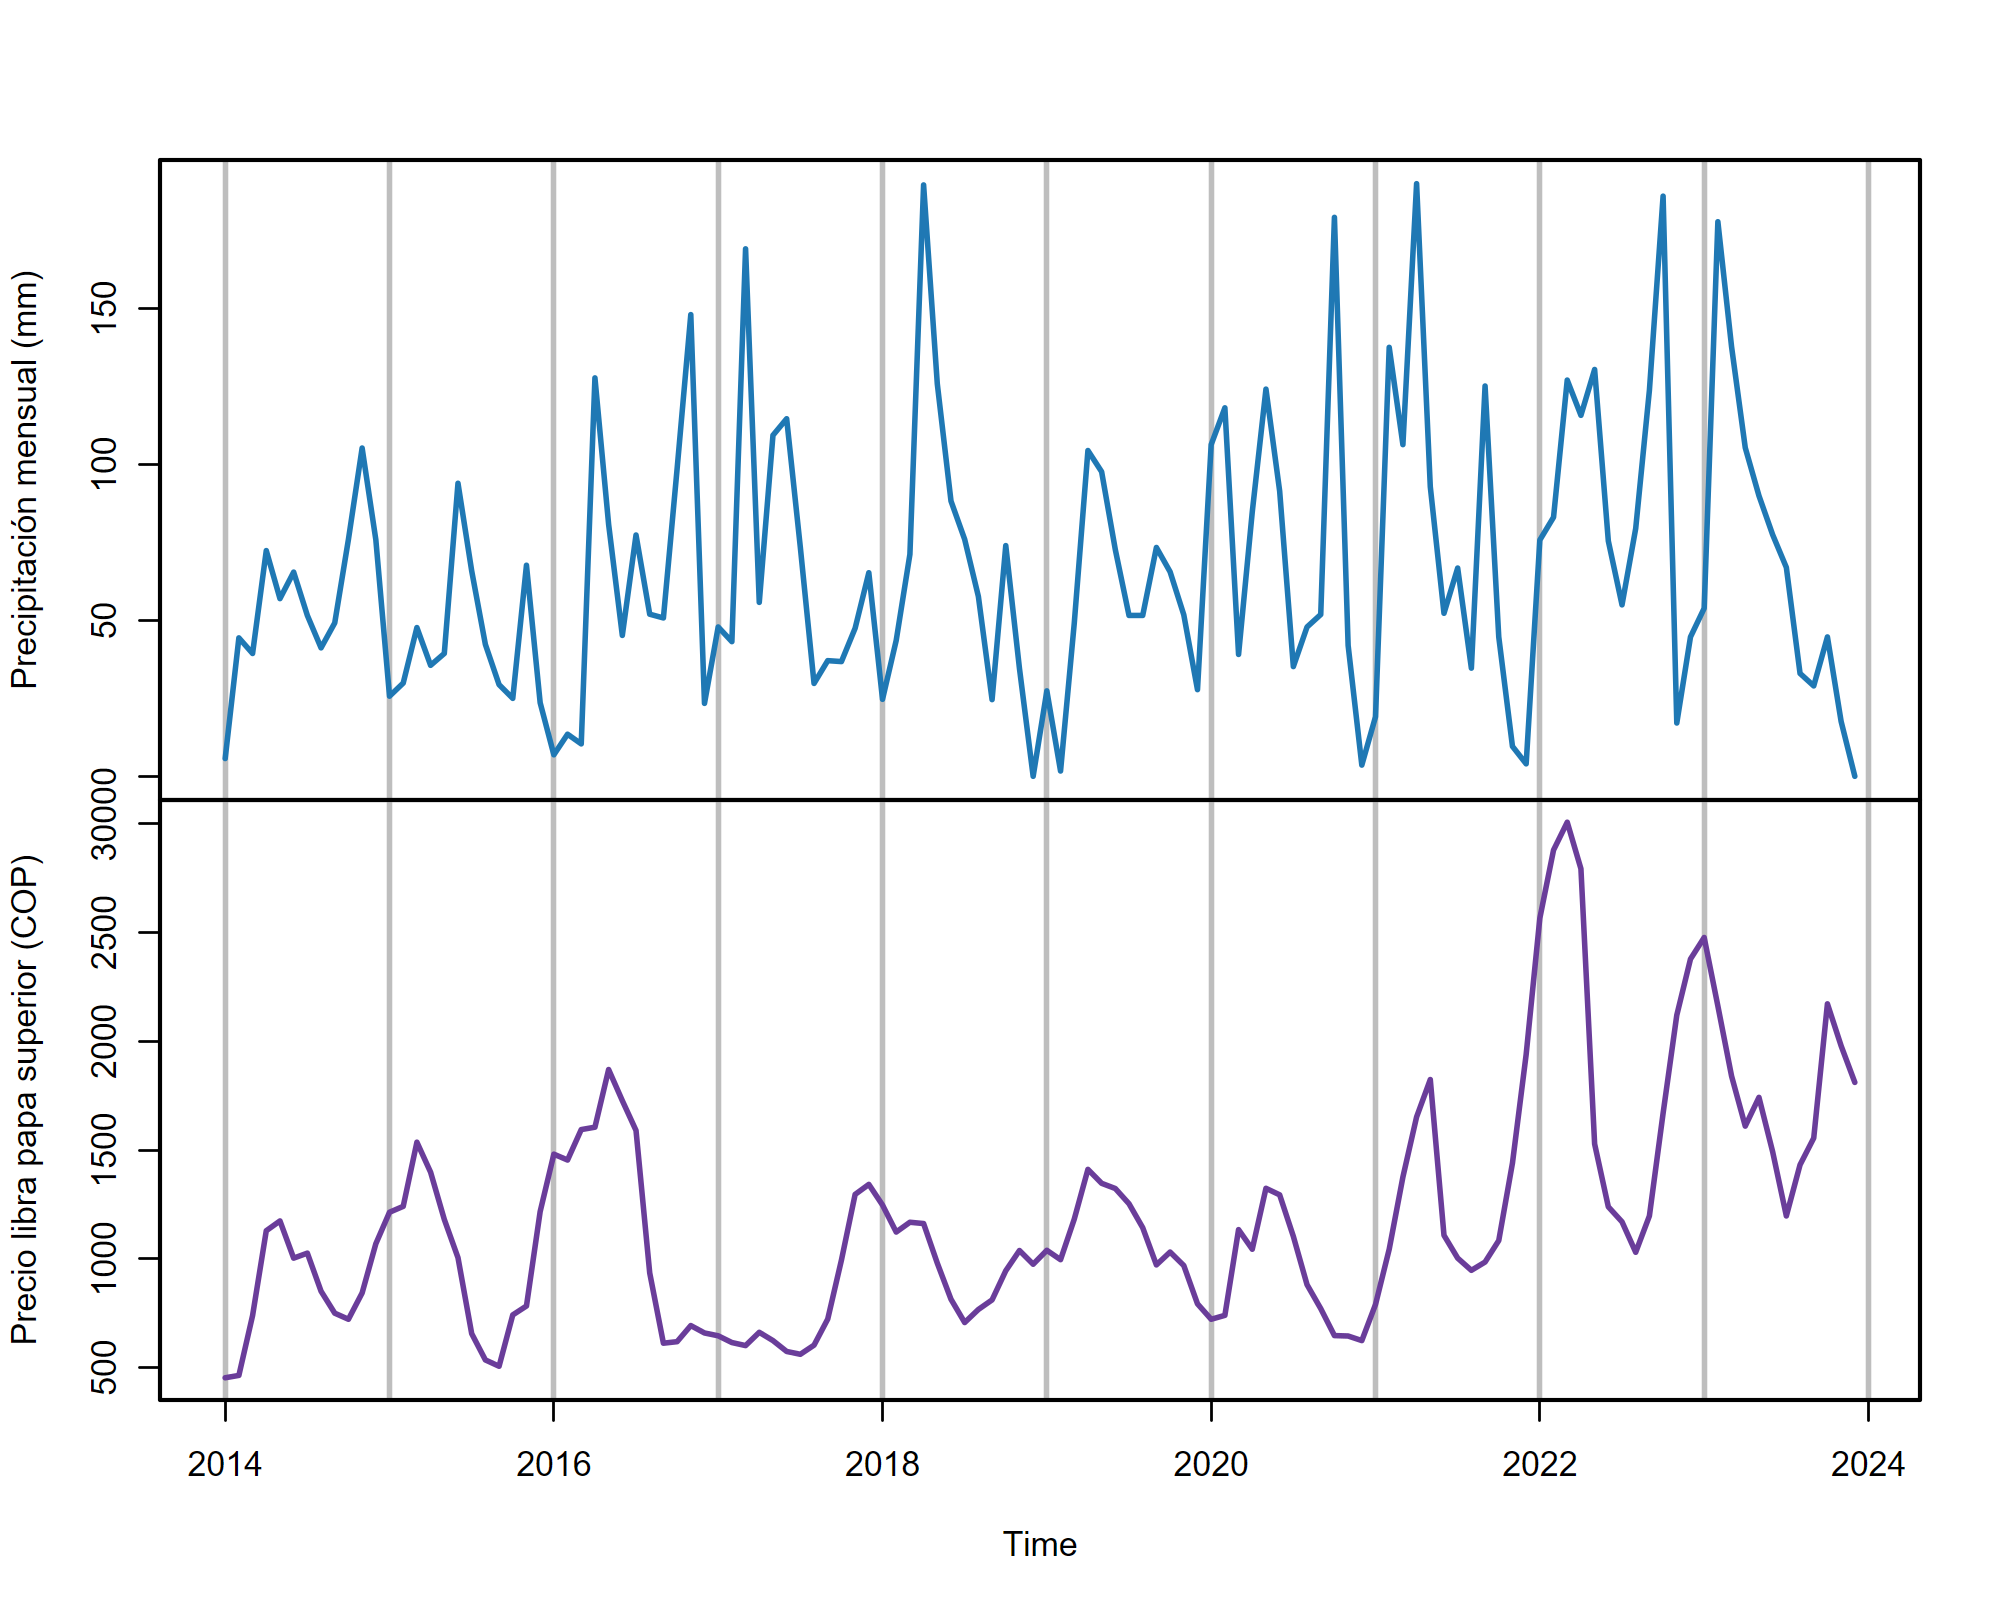

In [5]:
options(repr.plot.width = 10)  # Establece el ancho del gráfico a 10 pulgadas
options(repr.plot.height = 8)  # Opcional: ajusta la altura del gráfico
options(repr.plot.res = 200)

p = par()
par(mfrow = c(2,1), mar = c(0,4,4,2))
plot(exo2, axes = F, ylab = 'Precipitación mensual (mm)',
    type = 'l')
abline(v = 2014:2024, col = 'gray', lwd = 2)
lines(exo2, col = colores[2], lwd = 2)
box(lwd = 1.5); axis(2)
par(mar = p$mar)

par(mar = c(5,4,0,2))
plot(papa, bty = 'n', ylab = 'Precio libra papa superior (COP)')
abline(v = 2014:2024, col = 'gray', lwd = 2)
lines(papa, col = colores[10], lwd = 2)
box(lwd = 1.5)

Gráficamente puede argumentarse que existe cierta similaritud entre las dos series. Sin embargo, hay que revisar si esta coincidencia realmente existe o es sólo aparente.

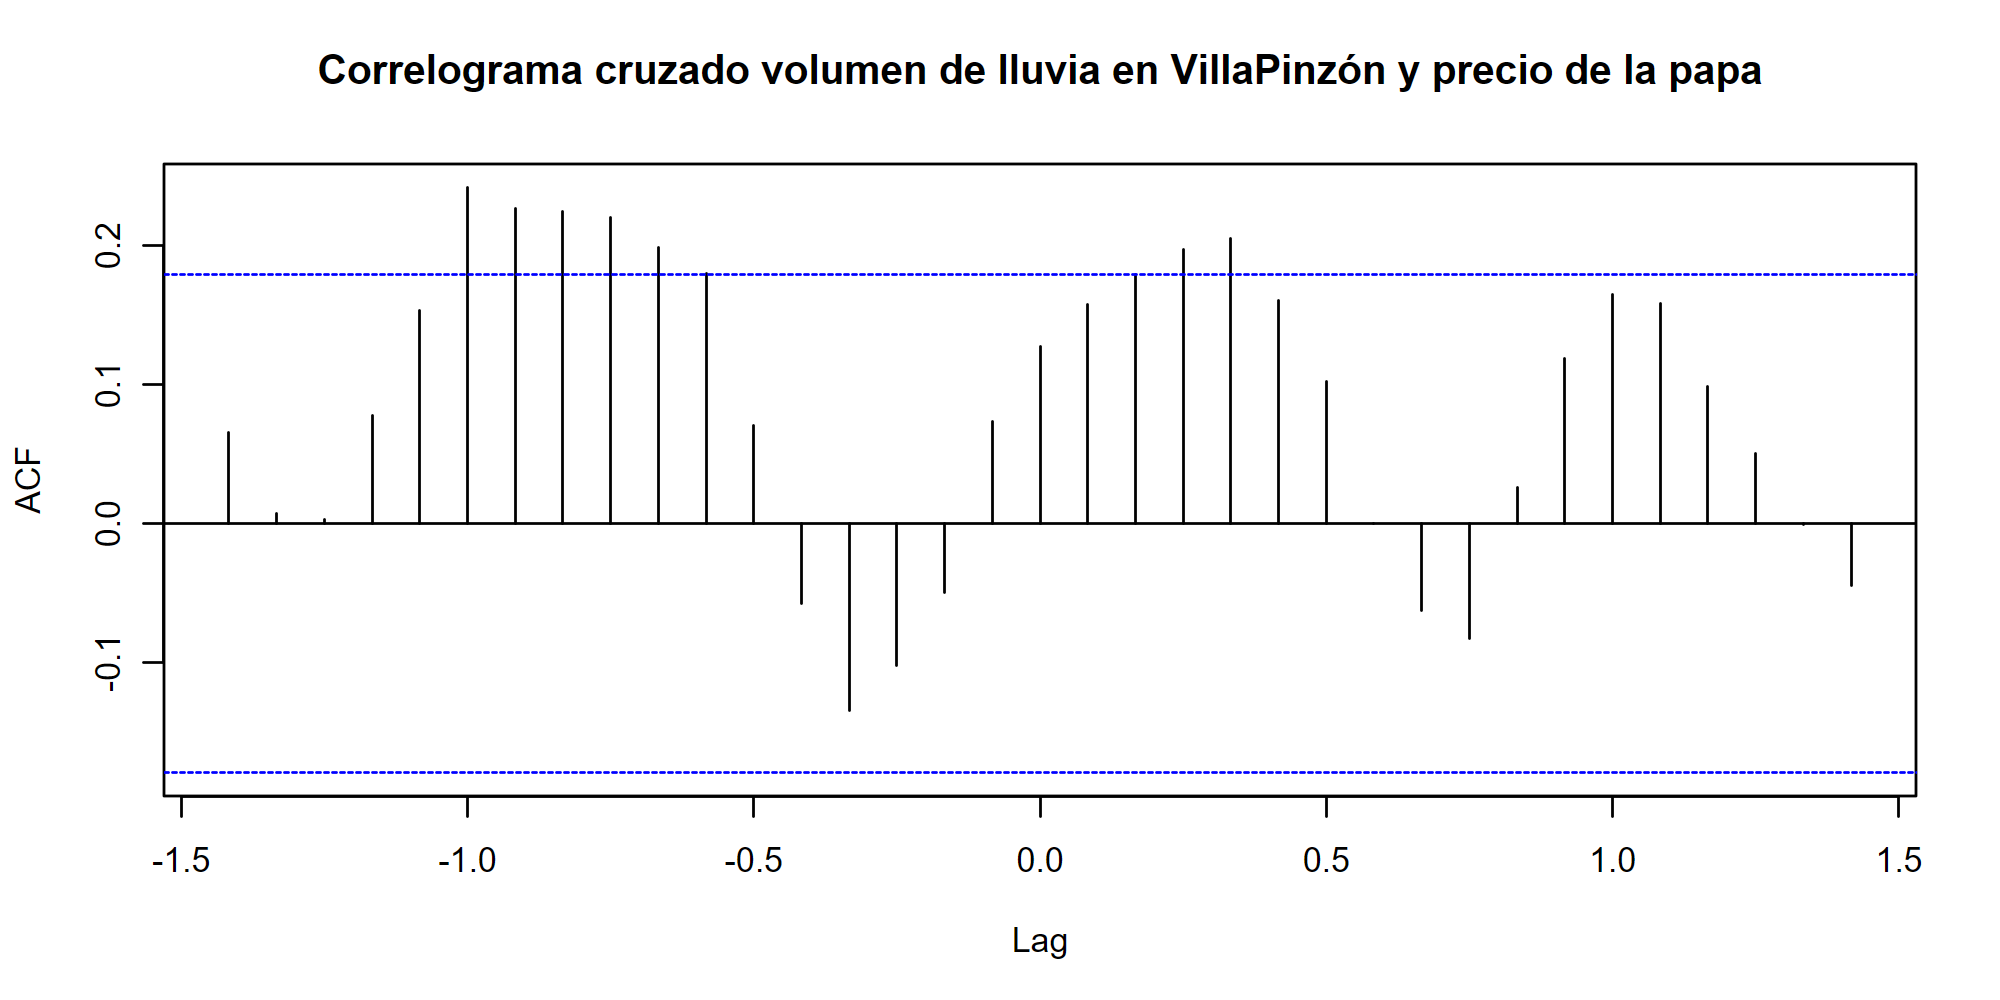

In [6]:
options(repr.plot.width = 10)  # Establece el ancho del gráfico a 10 pulgadas
options(repr.plot.height = 5)  # Opcional: ajusta la altura del gráfico
options(repr.plot.res = 200)
ccf(exo2, papa, main = 'Correlograma cruzado volumen de lluvia en VillaPinzón y precio de la papa') 
# Los lags se muestran en términos del volumen de lluvia en relación con el precio de la papa (i.e. Correlación 
# alta en lag -1 implica que los datos de un año antes de lluvias tienden a afectar el precio actual de la papa)
# Regresora = Lluvia
# Dependiente = Precio de la papa

### *[Pre blanqueo:](https://online.stat.psu.edu/stat510/lesson/9/9.1)*

En ocasiones, debido a que las series a las que le revisamos el correlograma cruzado son no estacionarias se puede incurrir mediante la inspección gráfica en relaciones espurias y otros problema. Por eso se aconseja: 

- Ajustar un modelo a $X$ (En este caso, la serie de lluvias).
- Guardar los residuales del modelo.
- Filtrar $Y$ con el modelo de $X$ (El precio de la papa).
- Revisar el **CCF** para los residuales.


In [7]:
exo2 = ts(exo[-c(121:145)], start = c(2014, 1), frequency = 12)   # exo2 se atrasa un año en relación con la serie original

In [8]:
pre_w = auto.arima(exo2)
pre_w

Series: exo2 
ARIMA(2,0,2)(0,0,2)[12] with non-zero mean 

Coefficients:
          ar1      ar2     ma1     ma2    sma1    sma2     mean
      -1.4034  -0.6344  1.6263  0.8946  0.1426  0.3185  67.9680
s.e.   0.1782   0.1653  0.1144  0.1047  0.1103  0.0978   5.5837

sigma^2 = 1525:  log likelihood = -607.97
AIC=1231.95   AICc=1233.25   BIC=1254.25

In [9]:
x = pre_w$residuals

# Coeficientes del modelo ARIMA
ar_coef <- c(-1.4034, -0.6344)  # Coeficientes AR
ma_coef <- c(1.6263, 0.8946)    # Coeficientes MA
sma_coef <- c(0.1426, 0.3185)   # Coeficientes SARMA

# Aplicar el filtro AR
y <- stats::filter(papa, filter = c(1, -ar_coef), method = "convolution", sides = 1)

# Aplicar el filtro MA
y <- stats::filter(y, filter = c(1, ma_coef), method = "convolution", sides = 1)

# Aplicar el filtro SARMA
y <- stats::filter(y, filter = c(1, sma_coef), method = "convolution", sides = 1)

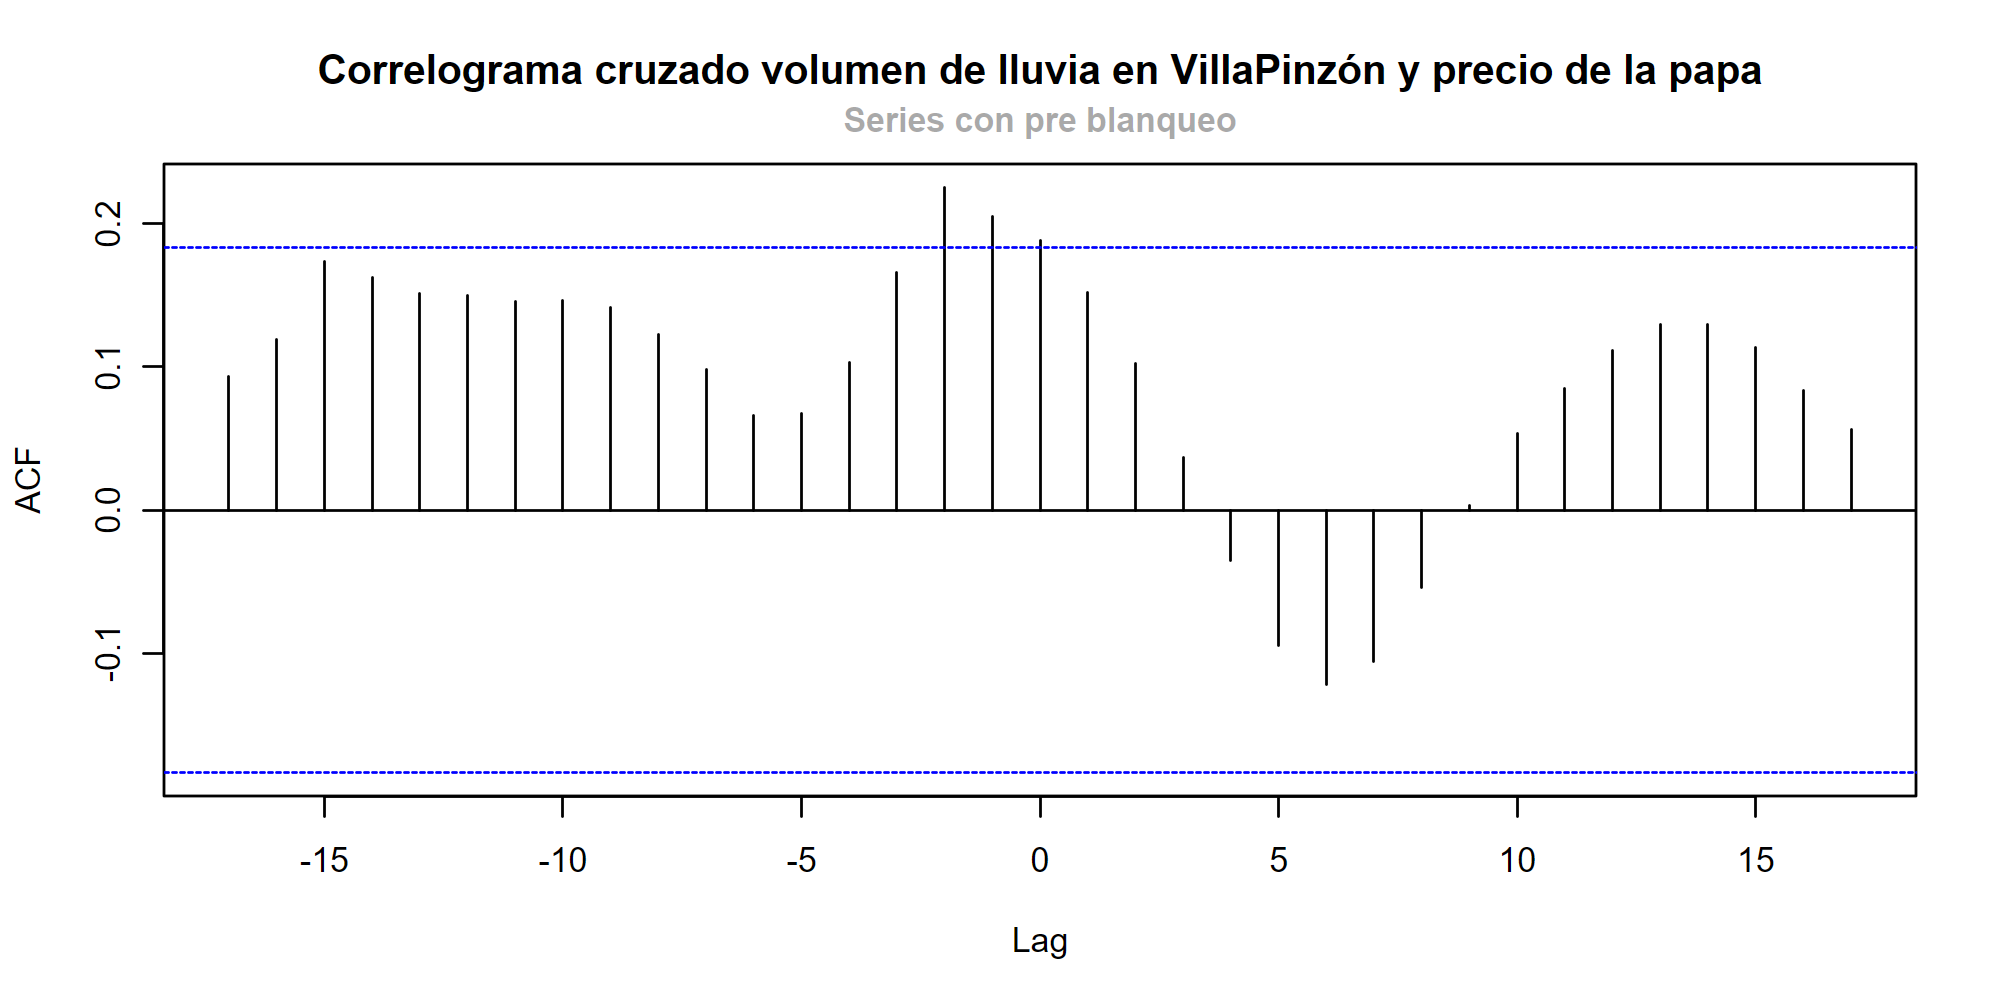

In [10]:
ccf(x[-c(1:6)], y[-c(1:6)], main = 'Correlograma cruzado volumen de lluvia en VillaPinzón y precio de la papa') 
mtext(side = 3, text = 'Series con pre blanqueo', col = 'darkgray', line = 0.7, font = 2)

Todo parece indicar que la variable exógena está,de hecho, correlacionada con el comportamiento actual de la serie del precio de la papa. 

In [11]:
save(exo2, file = 'exógenas.RData')

Idealmente, deben incluirse las variables exógenas estacionarias para evitar relaciones espurias.

In [12]:
exo2[72] <- 0.1 # Modificamos el valor que está en 0.0 para poder hacer BoxCox

In [13]:
exo2

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2014,18.0,66.0,48.8,69.5,155.1,23.3,66.8,73.4,40.5,61.0,148.1,41.7
2015,5.7,44.4,39.4,72.4,57.0,65.5,51.6,41.2,49.2,76.0,105.3,75.9
2016,25.7,29.9,47.7,35.6,39.4,94.0,65.9,42.3,29.4,25.0,67.7,23.6
2017,6.9,13.5,10.4,127.8,80.8,45.2,77.4,52.0,50.8,98.6,148.1,23.4
2018,47.9,43.2,169.2,55.8,109.4,114.7,73.4,29.8,37.1,36.8,47.5,65.3
2019,24.7,43.6,71.2,189.7,125.9,88.3,76.0,57.7,24.6,74.0,34.6,0.1
2020,27.4,1.7,49.0,104.5,97.7,72.7,51.6,51.6,73.4,65.6,51.8,27.8
2021,106.4,118.2,39.1,84.8,124.2,91.5,35.2,47.9,51.9,179.3,42.0,3.6
2022,19.1,137.6,106.4,190.1,92.9,52.3,66.8,34.7,125.2,44.7,9.6,4.0
2023,75.8,83.1,127.1,115.8,130.5,75.5,55.0,79.5,123.8,186.1,17.1,44.7


In [14]:
# Verificamos que su varianza sea estable y que sea estacionaria 
lambda_exo <- BoxCox.lambda(exo2)
lambda_exo

[1] -0.3982289

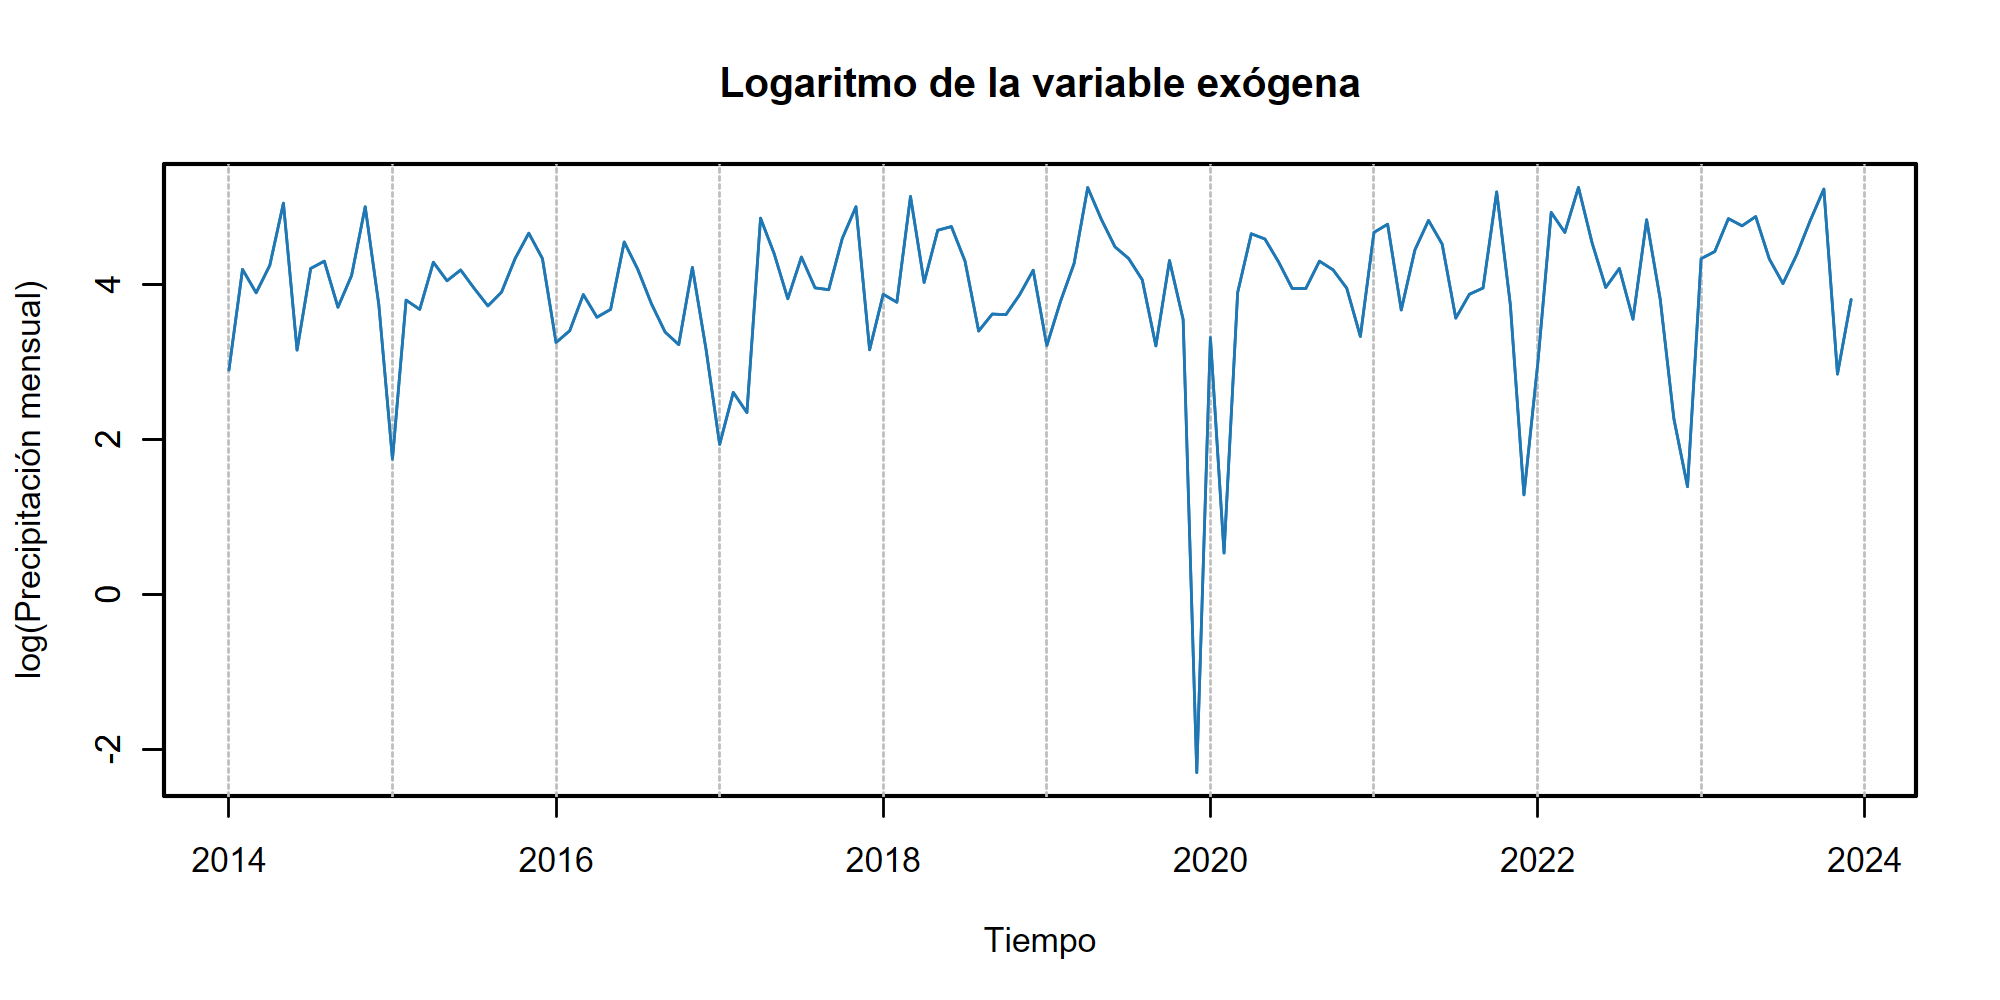

In [15]:
# Lambda es una valor cercano a 0, por lo que utilizaremos la transformación log
exo2l <- log(exo2)
plot(exo2l, ylab = 'log(Precipitación mensual)',
    type = 'l', col = colores[2], xlab = 'Tiempo',
    main = 'Logaritmo de la variable exógena')
box(lwd = 1.5); axis(2)
abline(v = 2014:2024, col = 'gray', lwd = 1, lty = 'dashed')
lines(exo2l, col = colores[2])

In [16]:
# Verificamos si es o no estacionaria 
adf.test(exo2l)
kpss.test(exo2l)

Warning message in adf.test(exo2l):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  exo2l
Dickey-Fuller = -4.8527, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


Warning message in kpss.test(exo2l):
"p-value greater than printed p-value"



	KPSS Test for Level Stationarity

data:  exo2l
KPSS Level = 0.070703, Truncation lag parameter = 4, p-value = 0.1


In [17]:
ndiffs(exo2l)

[1] 0

In [18]:
nsdiffs(exo2l)

[1] 0

# **Ajuste de modelos:**

Se ajustarán modelos tanto para la serie transformada como sin transformar: 

In [19]:
modelos = list()
train = ts(papa[1:114], start = c(2014,1), frequency = 12)

- **No estacionales:**
    - ARIMA(3,1,1)
    - ARIMAX(2,1,2) + precipitación mensual en VillaPinzón

In [20]:
modelos[['ARIMA(3,1,1)']] = auto.arima(train, seasonal = FALSE, lambda = 0)
modelos[['ARIMA(6,1,0)']] = Arima(train, order = c(6,1,0), lambda = 0)
modelos[['ARIMAX(2,1,2)']] = auto.arima(train, xreg = as.numeric(exo2l)[1:114], lambda = 0)

--- MICHEL

- **Con estacionalidad:**

    - SARIMA(3,1,1)(1,1,1)[6]
    - SARIMAX(3,1,1)(1,1,1)[6] + precipitación mensual

In [21]:
modelos[['SARIMA(3,1,1)(1,1,1)[6]']] = Arima(train, order = c(3,1,1), seasonal = list(order = c(1,1,1),period = 6), lambda = 0)
modelos[['SARIMAX(3,1,1)(1,1,1)[6]']] = Arima(train, order = c(3, 1, 1), seasonal = list(order = c(1, 1, 1), period = 6), xreg = exo2l[1:114], lambda = 0)
modelos[['SARIMA(3,1,1)(1,1,1)[6]']] = Arima(train, order = c(3,1,1), seasonal = list(order = c(1,1,1),period = 6), lambda = 0)
modelos[['SARIMAX(3,1,1)(1,0,0)[6]']] = Arima(train, order = c(3, 1, 1), seasonal = list(order = c(1, 0, 0), period = 6), xreg = exo2l[1:114], lambda = 0)
modelos[['SARIMA(6,1,0)(1,0,0)[6]']] = Arima(train, order = c(6, 1, 0), seasonal = list(order = c(1, 0, 0), period = 6), xreg = exo2l[1:114], lambda = 0)
# modelos[['lore acurate']] = Arima(train, order = c(3, 1, 1), seasonal = list(order = c(0, 0, 1), period = 6), xreg = exo2l[1:114], lambda = 0)
month_factor <- factor(rep(month.name, length.out = 114), levels = month.name)
month_dummies <- model.matrix(~ month_factor - 1)[,-1]  # One-hot encode months
# xreg_fixed <- cbind(as.numeric(exo2l)[1:114], month_dummies)  # Numeric matrix
modelos[['ARIMA(3,1,1)(2,0,0)[12] + Dummy']] = auto.arima(train, xreg = month_dummies, lambda = 0)
modelos[['SARIMA(3,1,1)(1,1,1)[12]']] = Arima(train, order = c(3,1,1), seasonal = list(order = c(1,1,1), period = 12), lambda = 0)
modelos[['SARIMAX(3,1,1)(1,0,0)[12]']] = Arima(train, order = c(3, 1, 1), seasonal = list(order = c(1, 0,0), period = 12), xreg = exo2l[1:114], lambda = 0)

- **Con las exógenas que sí son:**

In [22]:
exol = log(ts(exo[-c(1:10, 131:145)], start = c(2013, 11), frequency = 12))
exol[exol == -Inf] = 0.1
exol

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2013,,,,,,,,,,,4.9978877,3.7305011
2014,1.7404662,3.7932395,3.6737658,4.2822063,4.0430513,4.1820501,3.9435217,3.7184383,3.8958936,4.3307333,4.6568134,4.3294167
2015,3.2464910,3.3978585,3.8649314,3.5723456,3.6737658,4.5432948,4.1881384,3.7447871,3.3809947,3.2188758,4.2150862,3.1612467
2016,1.9315214,2.6026897,2.3418058,4.8504665,4.3919770,3.8110971,4.3489868,3.9512437,3.9278964,4.5910713,4.9978877,3.1527360
2017,3.8691155,3.7658405,5.1310814,4.0217739,4.6950109,4.7423200,4.2959239,3.3945084,3.6136170,3.6054978,3.8607297,4.1789920
2018,3.2068032,3.7750572,4.2654928,5.2454439,4.8354879,4.4807401,4.3307333,4.0552572,3.2027464,4.3040651,3.5438537,0.1000000
2019,3.3105430,0.5306283,3.8918203,4.6491871,4.5819016,4.2863414,3.9435217,3.9435217,4.2959239,4.1835757,3.9473901,3.3250360
2020,4.6672056,4.7723781,3.6661225,4.4402955,4.8218932,4.5163390,3.5610461,3.8691155,3.9493188,5.1890604,3.7376696,1.2809338
2021,2.9496883,4.9243509,4.6672056,5.2475502,4.5315236,3.9569964,4.2017031,3.5467397,4.8299125,3.7999735,2.2617631,1.3862944
2022,4.3280983,4.4200447,4.8449742,4.7518646,4.8713732,4.3241327,4.0073332,4.3757570,4.8186674,5.2262842,2.8390785,3.7999735


In [23]:
modelos[['Regresion dos meses']] = auto.arima(train, xreg = as.numeric(exol)[1:114])

- **Dejando a `auto.arima` hacer todo el trabajo:**
    - ARIMA(2,1,2)
    - ARIMA(2,1,2)(0,0,1)[12]  

In [24]:
modelos[['ARIMA(2,1,2)-noBoxCox']] = auto.arima(papa[1:114])
modelos[['SARIMA(2,1,2)(0,0,1)[12]-noBoxCox']] = auto.arima(ts(papa[1:114], frequency = 12, start = c(2014, 1)))

# **Selección de modelos:**

In [25]:
medidas = do.call(cbind, lapply(modelos, FUN = function(x){
    rbind('aic' = x$aic,
         'bic' = x$bic,
         'loglik' = x$loglik,
         'aicc' = x$aicc, 
         'mse' = mean(x$residuals ^2),
         'rmse' = sqrt(mean(x$residuals ^2)))
}))

colnames(medidas) = names(modelos)
medidas = medidas[, order(medidas["aic", ])]
medidas

,"ARIMA(3,1,1)(2,0,0)[12] + Dummy","ARIMAX(2,1,2)","ARIMA(3,1,1)","SARIMAX(3,1,1)(1,0,0)[6]","SARIMAX(3,1,1)(1,0,0)[12]","SARIMA(6,1,0)(1,0,0)[6]","ARIMA(6,1,0)","SARIMA(3,1,1)(1,1,1)[6]","SARIMAX(3,1,1)(1,1,1)[6]","SARIMA(3,1,1)(1,1,1)[12]","SARIMA(2,1,2)(0,0,1)[12]-noBoxCox","ARIMA(2,1,2)-noBoxCox",Regresion dos meses
aic,-102.26624374,-90.89835384,-90.25624023,-88.83811173,-88.81664868,-84.63254257,-84.05471501,-68.68345503,-67.64136973,-61.06042026,1521.8921,1523.1434,1523.7934
bic,-53.17326301,-74.53402693,-76.61930113,-69.74639700,-69.72493395,-60.08605220,-64.96300028,-49.97365319,-46.25873906,-42.75457664,1538.2564,1536.7803,1542.8851
loglik,69.13312187,51.44917692,50.12812011,51.41905587,51.40832434,51.31627128,49.02735751,41.34172751,41.82068487,37.53021013,-754.9461,-756.5717,-754.8967
aicc,-94.98964800,-90.10590101,-89.69549256,-87.77144506,-87.74998202,-82.88496975,-82.98804835,-67.55214190,-66.17198198,-59.85611918,1522.6846,1523.7041,1524.8601
mse,0.01639262,0.02308063,0.02360954,0.02307425,0.02307958,0.02315922,0.02414665,0.02072299,0.02052658,0.01830328,36329.7856,37521.0318,36309.2993
rmse,0.12803367,0.15192311,0.15365395,0.15190209,0.15191966,0.15218155,0.15539192,0.14395482,0.14327101,0.13528961,190.6037,193.7035,190.5500


Para estudiar los modelos seleccionaremos los primeros 3 en cuanto a AIC (Que también son buenos en los demás criterios). Revisemos las raíces de cada uno de los modelos:

In [26]:
selected_models = modelos[colnames(medidas)[2:4]]

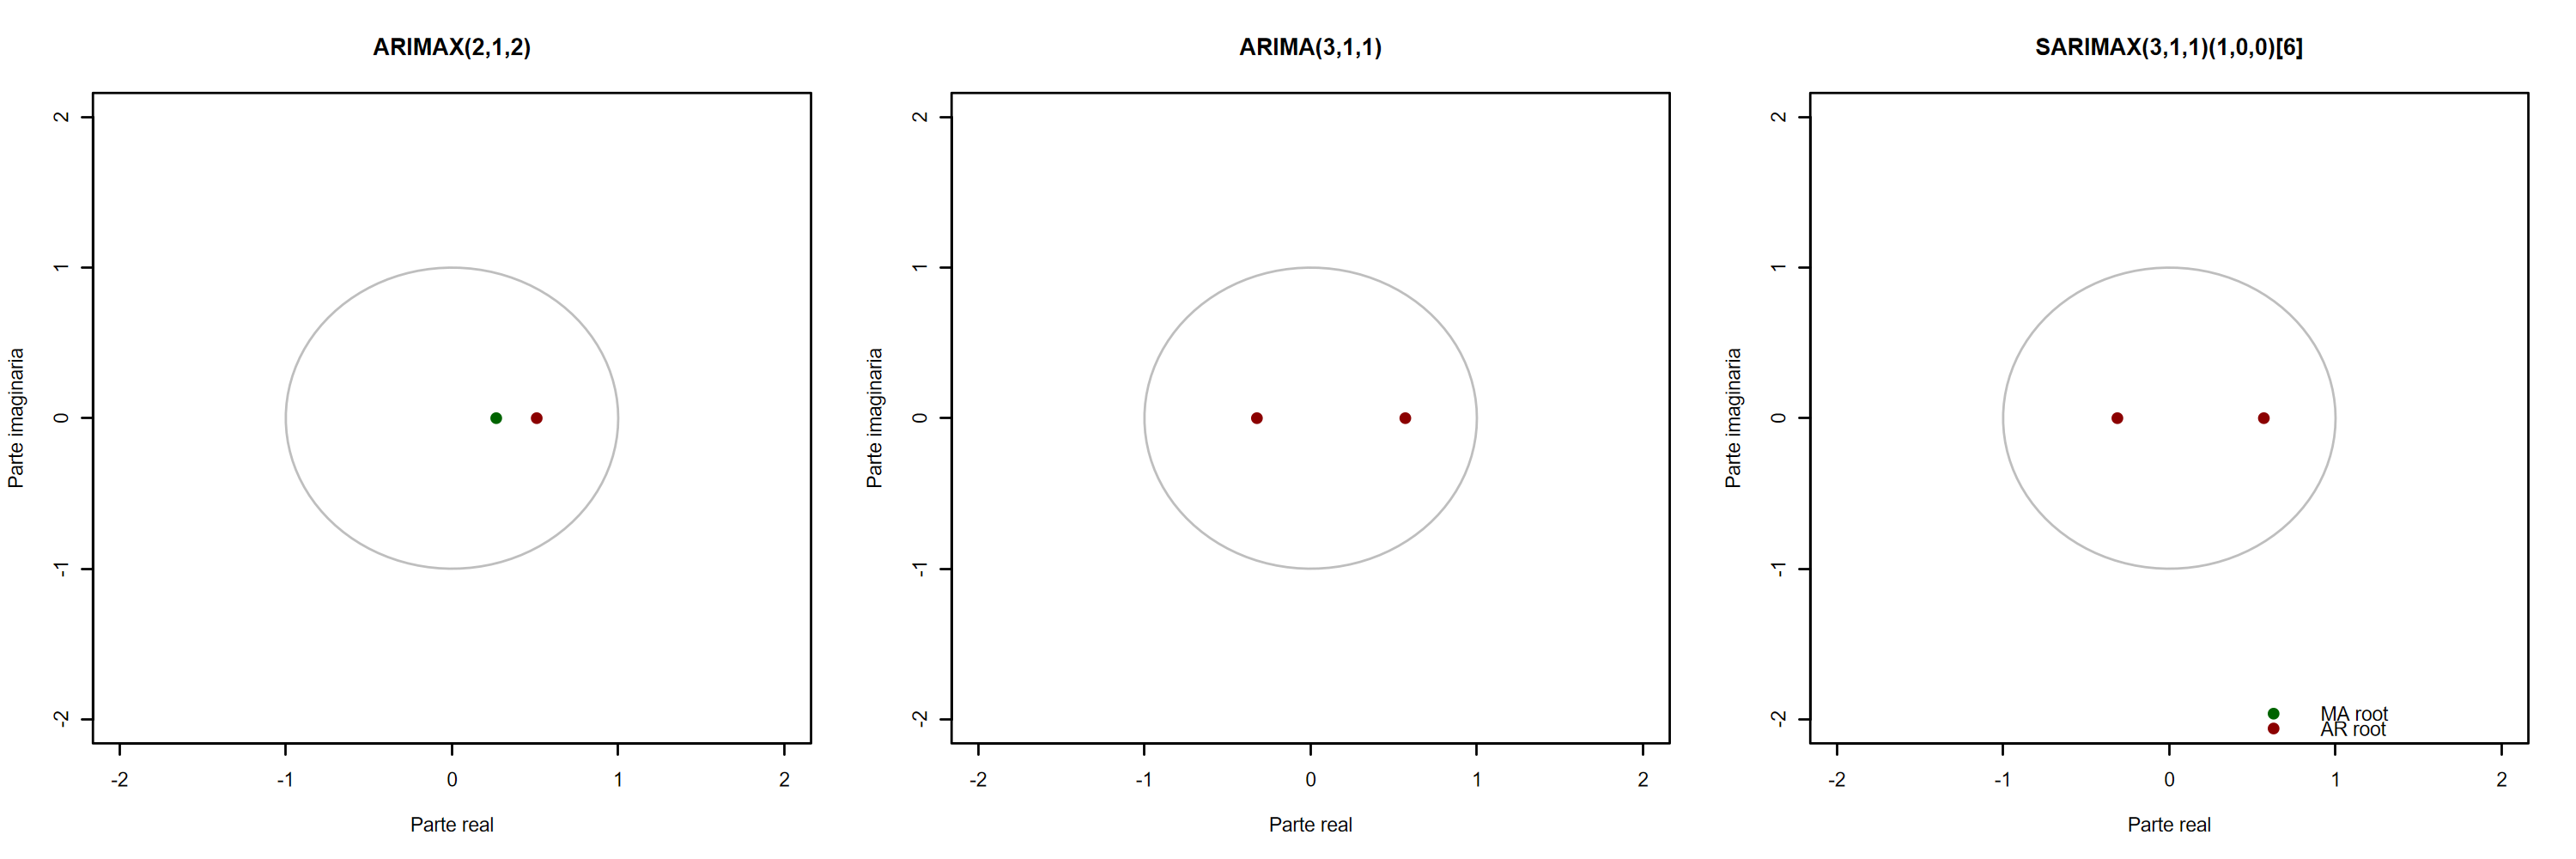

In [27]:
options(repr.plot.width = 15)  # Establece el ancho del gráfico a 10 pulgadas
options(repr.plot.height = 5)  # Opcional: ajusta la altura del gráfico
options(repr.plot.res = 200)

par(mfrow = c(1,3))
# Supongamos que 'selected_models' es una lista de modelos ARIMA
for (i in names(selected_models)) {
    modelo = selected_models[[i]]
    
    # Extraer coeficientes AR y MA
    ar_coef = modelo$coef[stringr::str_detect(names(modelo$coef), '^ar')]  # Coeficientes AR
    ma_coef = modelo$coef[stringr::str_detect(names(modelo$coef), '^ma')]  # Coeficientes MA

    # Calcular raíces de los polinomios AR y MA
    ar_roots = polyroot(ar_coef)  # Raíces del polinomio AR
    ma_roots = polyroot(ma_coef)   # Raíces del polinomio MA
    
    plot(0, 0, type = "n", xlim = c(-2, 2), ylim = c(-2, 2),
         xlab = "Parte real", ylab = "Parte imaginaria",
         main = i)
    
    theta <- seq(0, 2*pi, length.out = 100)
    lines(cos(theta), sin(theta), col = "gray")
    
    # Graficar raíces AR
    points(1/Re(ar_roots), Im(ar_roots), col="darkred", pch=19)/
    
    # Graficar raíces MA
    points(1/Re(ma_roots), Im(ma_roots), col="darkgreen", pch=19)
}
legend('bottomright', legend = c('MA root', 'AR root'), col = c('darkgreen', 'darkred'), pch = 19, bty = 'n', )

# **Validación de supuestos**

## Estacionariedad

In [28]:
pruebas = do.call(rbind,
                  (lapply(selected_models,
                          function(x) adf.test(x$residuals)$p.value)))
pruebas = cbind(pruebas, 
               'nsdiffs' = do.call(rbind, 
                       lapply(selected_models, 
                              function(x) nsdiffs(x$residuals))), 
               'jarque bera' = do.call(rbind,
                                      lapply(selected_models, 
                                            function(x) jarque.bera.test(x$residuals)$p.value)))
colnames(pruebas) = c('adf', 'nsdiffs', 'jarque bera')
pruebas

Warning message in adf.test(x$residuals):
"p-value smaller than printed p-value"
Warning message in adf.test(x$residuals):
"p-value smaller than printed p-value"
Warning message in adf.test(x$residuals):
"p-value smaller than printed p-value"


,adf,nsdiffs,jarque bera
"ARIMAX(2,1,2)",0.01,0,0.3387248
"ARIMA(3,1,1)",0.01,0,0.2319482
"SARIMAX(3,1,1)(1,0,0)[6]",0.01,0,0.3621346


[[1]]

Partial autocorrelations of series 'selected_models[[x]]$residuals', by lag

0.0833 0.1667 0.2500 0.3333 0.4167 0.5000 0.5833 0.6667 0.7500 0.8333 0.9167 
-0.033  0.002  0.032  0.031 -0.063 -0.008  0.052 -0.118 -0.046 -0.072  0.141 
1.0000 1.0833 1.1667 1.2500 1.3333 1.4167 1.5000 1.5833 1.6667 
 0.027 -0.074  0.003 -0.226 -0.088  0.059  0.053  0.107 -0.089 

[[2]]

Partial autocorrelations of series 'selected_models[[x]]$residuals', by lag

0.0833 0.1667 0.2500 0.3333 0.4167 0.5000 0.5833 0.6667 0.7500 0.8333 0.9167 
-0.028 -0.035  0.032  0.043 -0.068  0.010  0.054 -0.107 -0.068 -0.050  0.164 
1.0000 1.0833 1.1667 1.2500 1.3333 1.4167 1.5000 1.5833 1.6667 
 0.046 -0.055  0.013 -0.234 -0.088  0.029  0.071  0.096 -0.065 

[[3]]

Partial autocorrelations of series 'selected_models[[x]]$residuals', by lag

0.0833 0.1667 0.2500 0.3333 0.4167 0.5000 0.5833 0.6667 0.7500 0.8333 0.9167 
-0.034 -0.045  0.059  0.042 -0.068 -0.022  0.052 -0.101 -0.032 -0.060  0.158 
1.0000 1.0833 1.1667 1

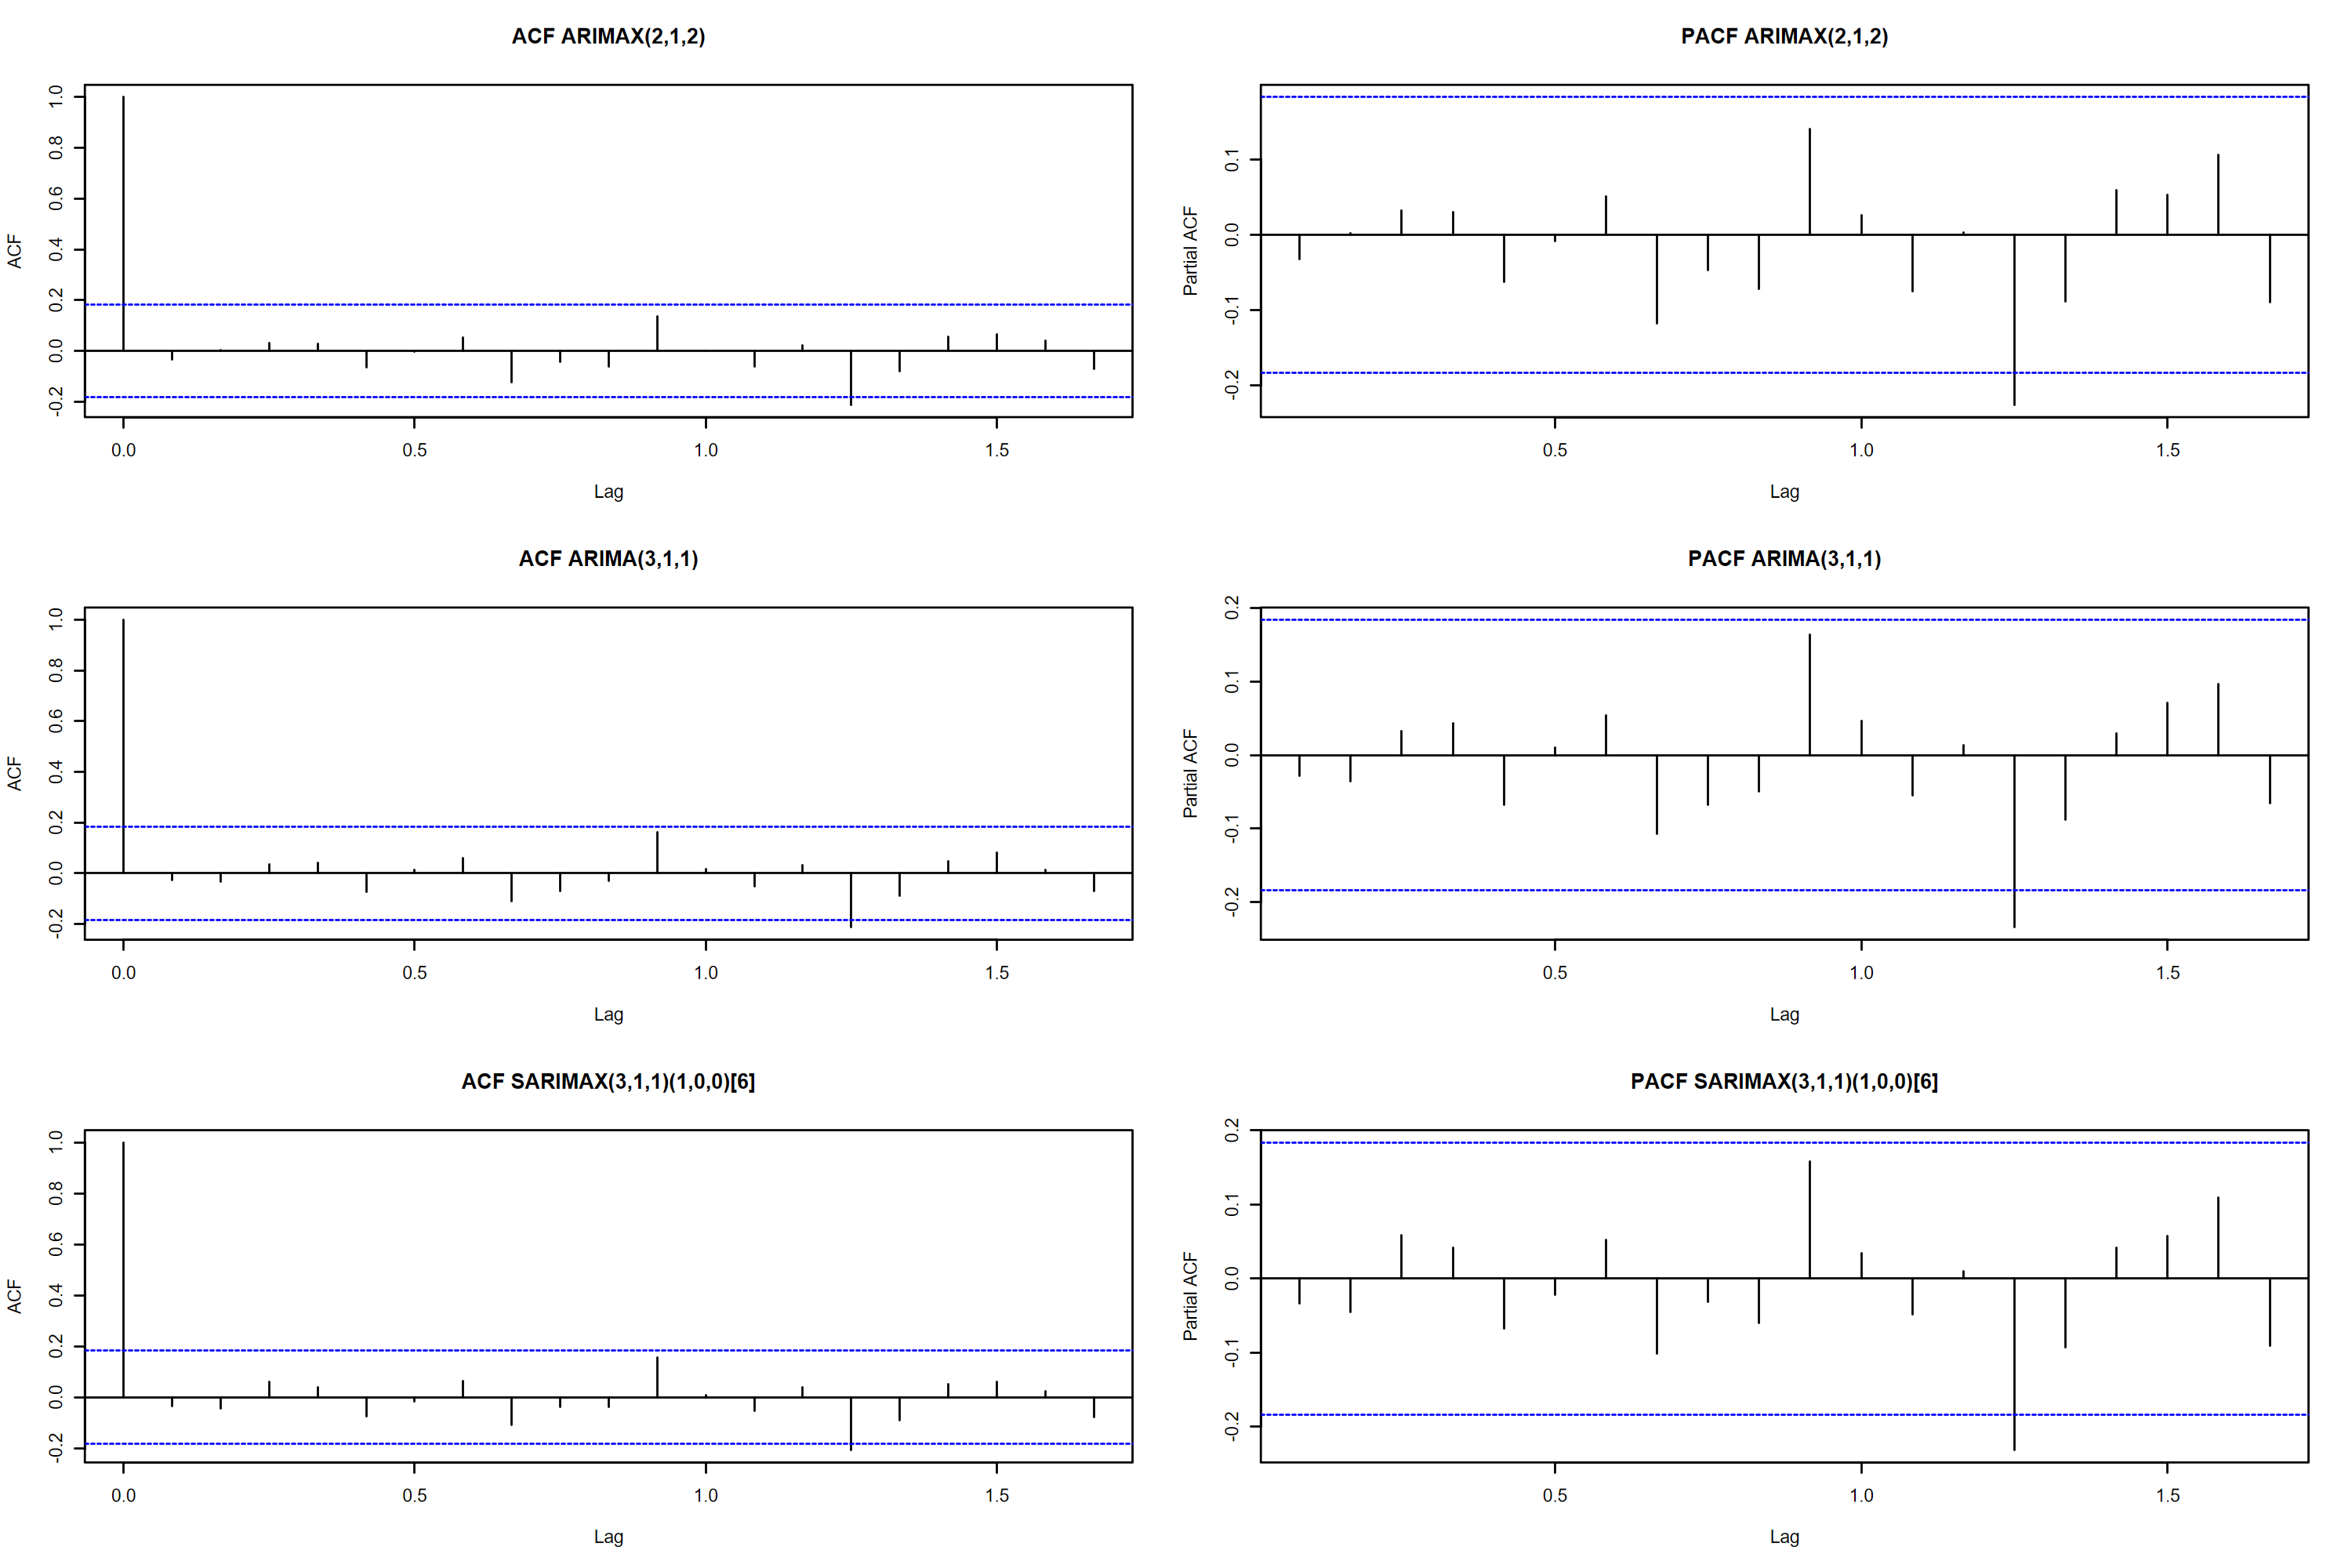

In [29]:
options(repr.plot.height = 10)

par(mfrow = c(3,2))
lapply(names(selected_models),
      function(x){
          acf(selected_models[[x]]$residuals, 
             main = paste('ACF', x))
          pacf(selected_models[[x]]$residuals, 
             main = paste('PACF', x))
      })

$`ARIMAX(2,1,2)`
NULL

$`ARIMA(3,1,1)`
NULL

$`SARIMAX(3,1,1)(1,0,0)[6]`
NULL

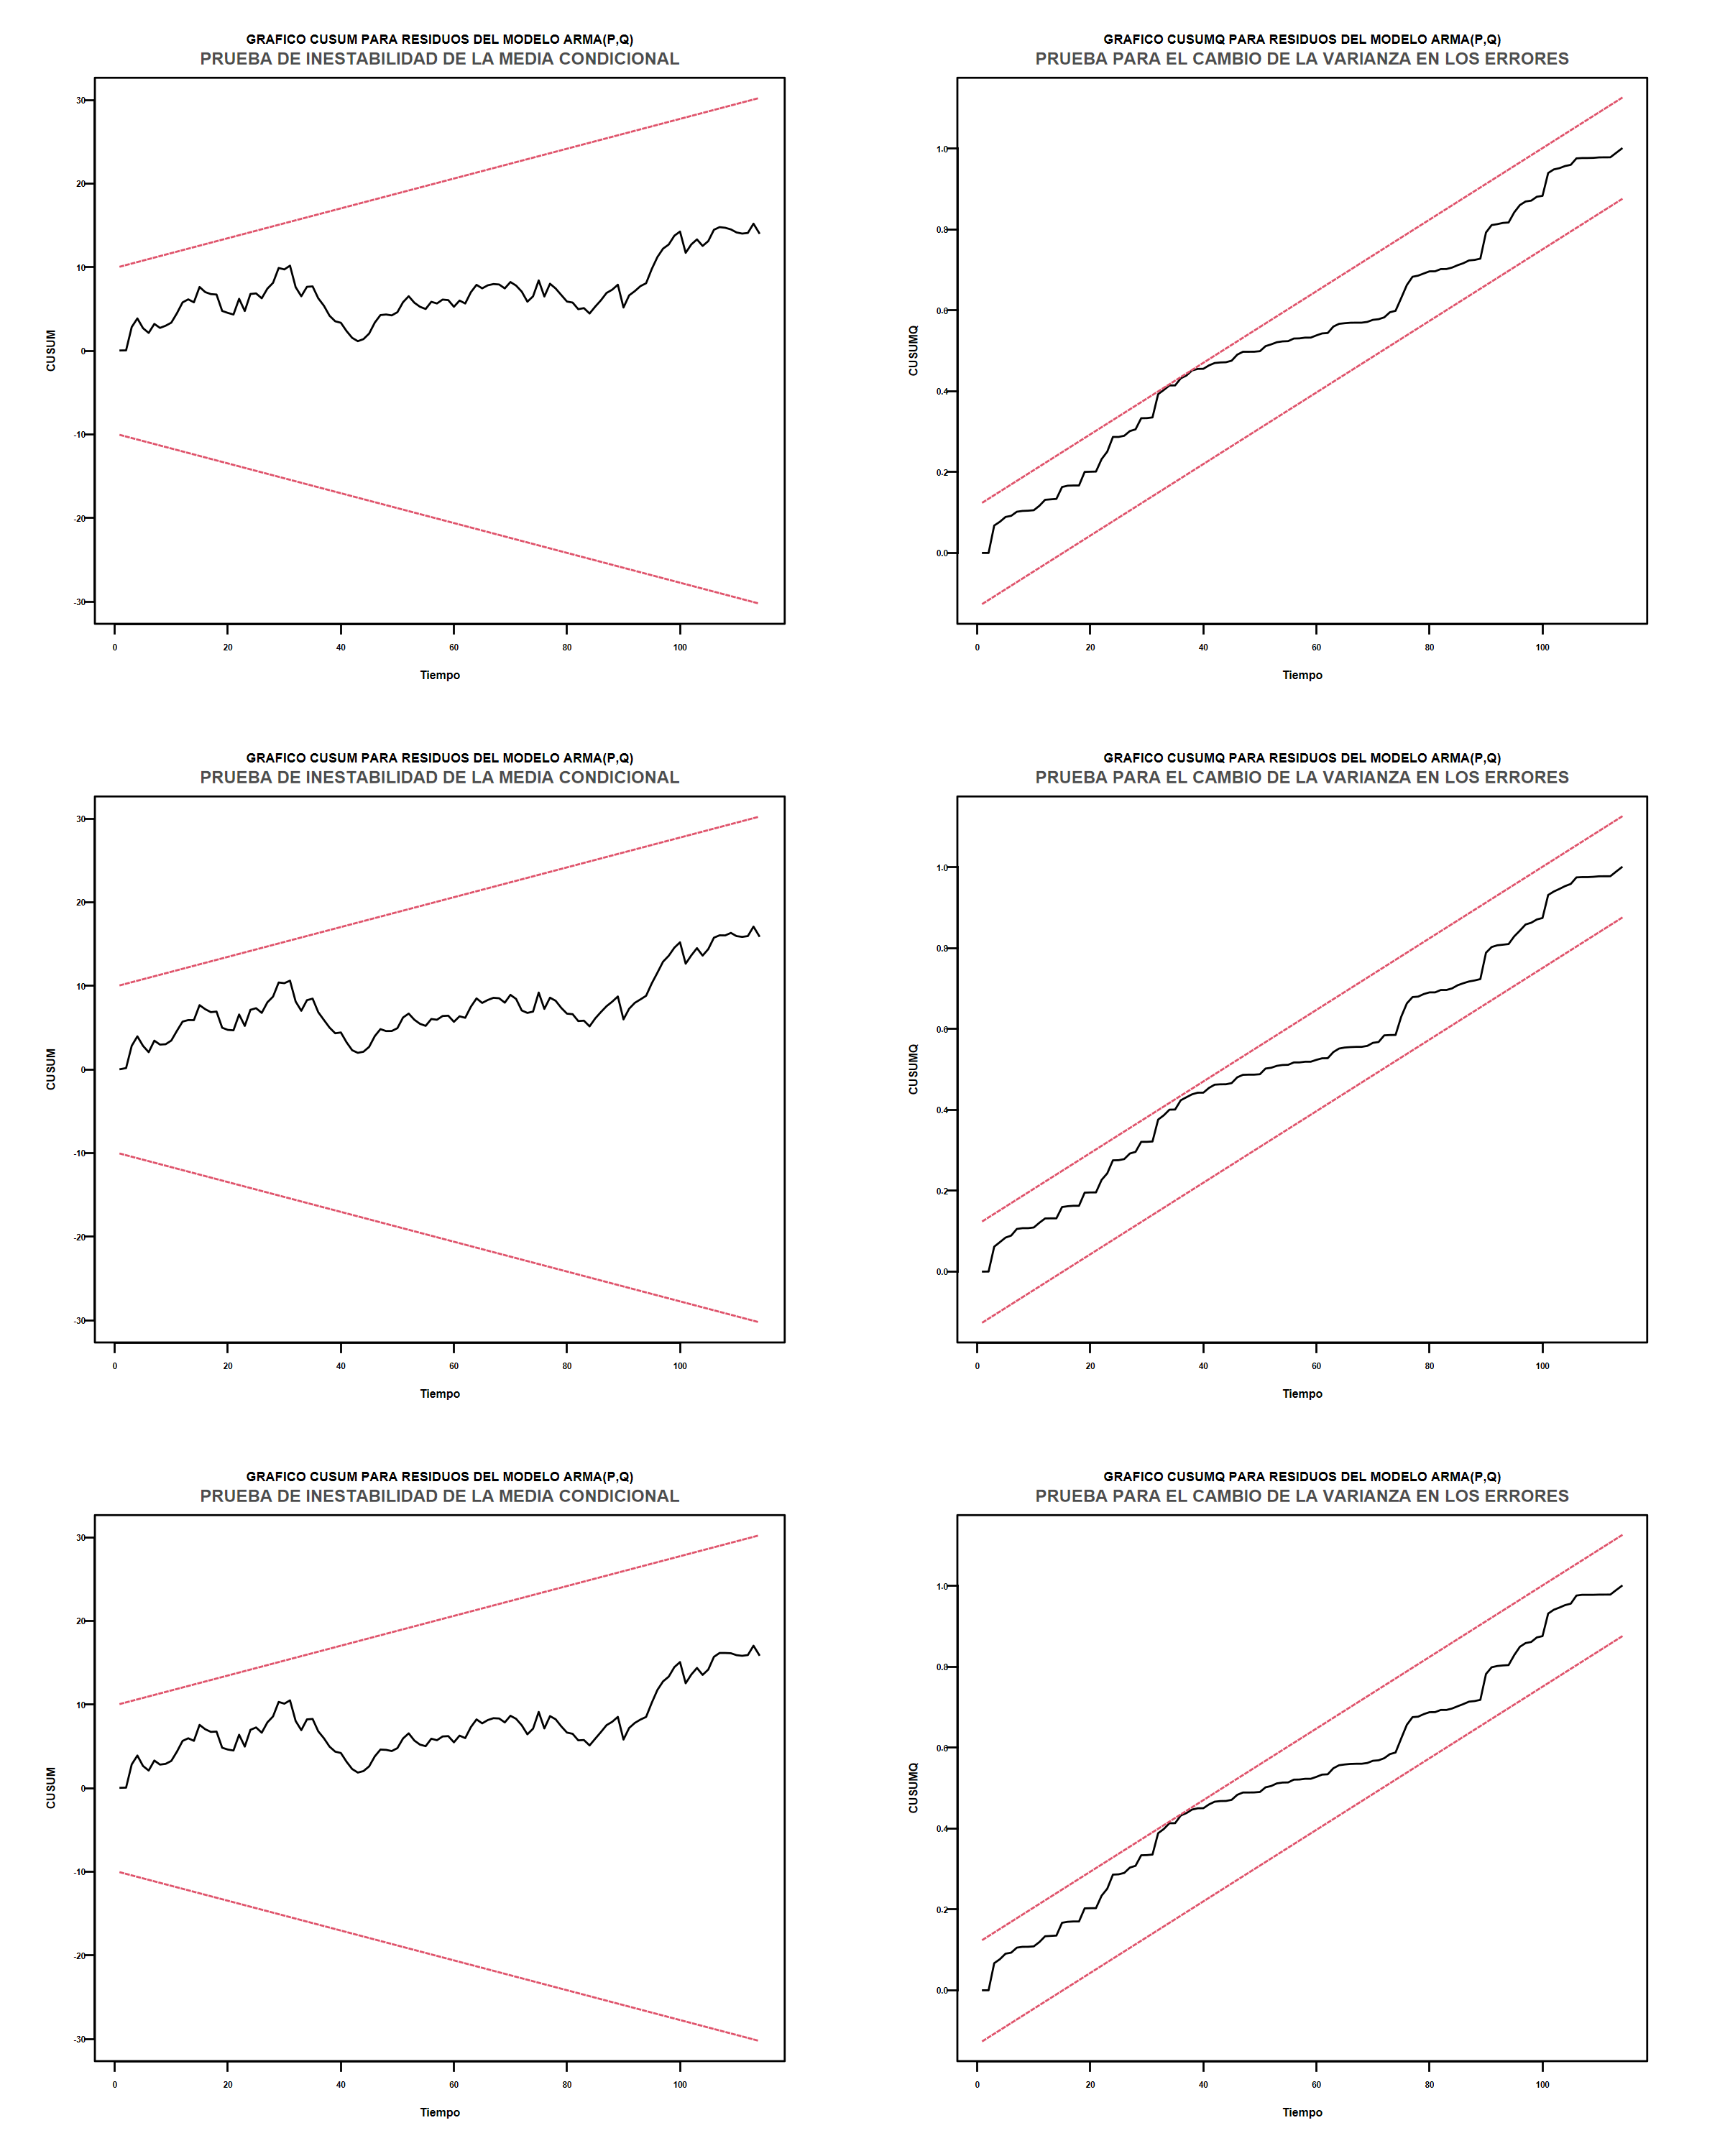

In [30]:
cucuq <- function(x, nivel = C0){ 
  
  A <- 0.948 
  N <- length(x)
  K <- 0
  T <- 1:N
  n <- (1/2)*N
  
  C <- data.frame(
    C0 = c(0.12522, 0.12170, 0.11848, 0.11409, 0.11017, 
           0.10777, 0.10446, 0.10241, 0.09506, 0.08293, 
           0.05960, 0.05190),
    n = c(61, 65, 69, 75, 81, 85, 91, 95, 150, 200, 300, 400)
  )
  
  # Interpolación para obtener C0 en función de n
  C0 <- approx(C$n, C$C0, xout = n, rule = 2)$y
  
  
  cu <- cumsum(x)/sd(x)
  LS <- A*sqrt(N-K-1)+2*A*(T-K-1)/sqrt(N-K-1)
  LI <- -LS
  
  cu2 <- cumsum(x*x)/sum(x*x)
  LS2 <- nivel+(T-K-1)/(N-K-1)
  LI2 <- -nivel+(T-K-1)/(N-K-1)
  
  y <- cbind(cu,LS,LI)
  y2 <- cbind(cu2,LS2,LI2)
  
  par(mar = c(5, 5, 4.1, 4.1), #mar = c(3, 6, 4, 3), 
      bg = 'white', las = 0, mgp = c(2, 0.5, 0))
  par(las=1)
  matplot(x = (1:N), y, main = "GRAFICO CUSUM PARA RESIDUOS DEL MODELO ARMA(P,Q)",
          xlab="Tiempo", ylab= "CUSUM", type ="l", col = c(1,2,2), lwd = 1, lend = 2,
          lty = c(1,2,2), family = "sans", font.lab = 2, cex.lab = 0.7, font = 2,
          font.main = 2, cex.main = 0.8, cex.axis = 0.5, col.main = 'black')
  mtext("PRUEBA DE INESTABILIDAD DE LA MEDIA CONDICIONAL", side = 3, line = 0.6,
        font = 2, cex = 0.7, col = 'grey30')
  
  
  par(las=1)
  matplot(x=(1:N), y2, main = "GRAFICO CUSUMQ PARA RESIDUOS DEL MODELO ARMA(P,Q)",
          xlab="Tiempo", ylab= "CUSUMQ", type ="l", col = c(1,2,2), lwd = 1, lend = 2,
          lty = c(1,2,2), family = "sans", font.lab = 2, cex.lab = 0.7, font = 2,
          font.main = 2, cex.main = 0.8, cex.axis = 0.5, col.main = 'black')
  mtext("PRUEBA PARA EL CAMBIO DE LA VARIANZA EN LOS ERRORES", side = 3, line = 0.6,
        font = 2, cex = 0.7, col = 'grey30')
  
  # shapiro.test(x)
}

par(mfrow = c(3,2))

options(repr.plot.width = 12)
options(repr.plot.height = 15)

lapply(selected_models, function(x) cucuq(x$residuals))

## *Predicciones*

In [31]:
predicciones = matrix(NA, nrow = 6, ncol = 3)
colnames(predicciones) = names(selected_models)
predicciones[,1] = forecast::forecast(selected_models[[1]], h = 6, xreg = log(exo[115:120]))$mean
predicciones[,2] = forecast::forecast(selected_models[[2]], h = 6)$mean
predicciones[,3] = forecast::forecast(selected_models[[3]], h = 6, xreg = log(exo[115:120]))$mean
predicciones

"ARIMAX(2,1,2)","ARIMA(3,1,1)","SARIMAX(3,1,1)(1,0,0)[6]"
1444.177,1450.620,1447.193
1479.955,1442.877,1451.861
1566.370,1495.349,1516.107
1676.888,1572.199,1604.570
1702.495,1653.185,1628.166
1795.924,1715.809,1710.760


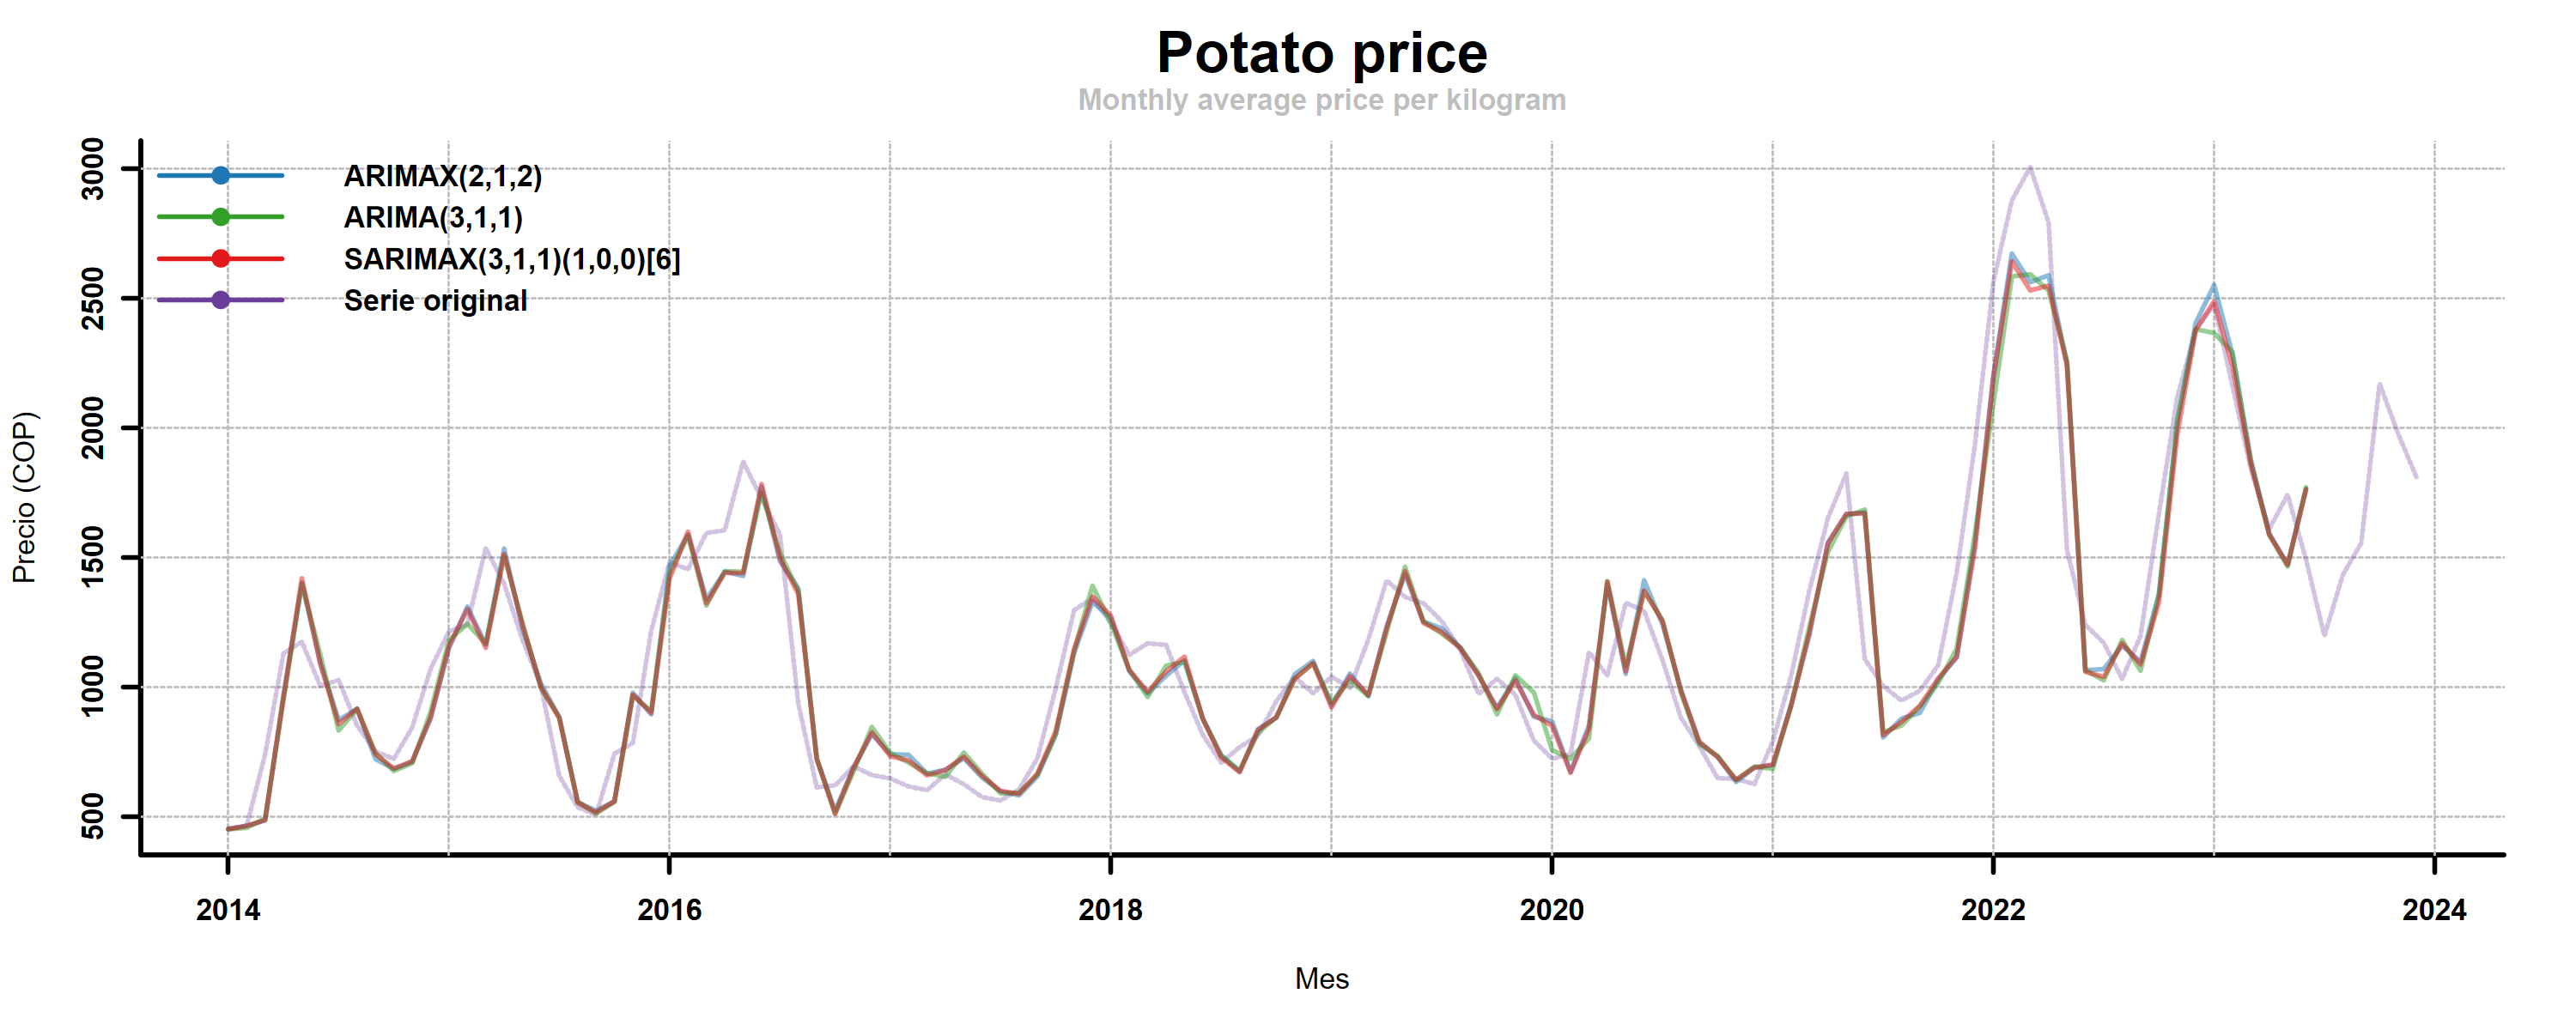

In [32]:
colores <- RColorBrewer::brewer.pal(n = 11, name = 'Paired')
color = colores[10]

options(repr.plot.height = 6)
options(repr.plot.width = 15)

plot(papa, bty = 'n', type = 'n', ylab = 'Precio (COP)', xlab = 'Mes', lty = 'dashed')
box(bty = 'l', lwd = 2)
title(main = 'Potato price', cex.main = 2, line = 2)
mtext(bquote(bold('Monthly average price per kilogram')), side = 3,
      col = 'gray', line = 0.6, cex = 1)
axis(1, lwd = 2, font = 2); axis(2, lwd = 2, font = 2); box(bty = 'l', lwd = 2)
abline(v = 2013:2024, col = 'gray', lty = 'dashed')                       # Reference lines
abline(h = seq(0, 5000, by = 500), col = 'gray', lty = 'dashed')
lines(papa, col = adjustcolor(color, 0.3), lwd = 2, lty = 'dashed')

for (i in 1:3){
    lines(selected_models[[i]]$fitted, lwd = 2, col = adjustcolor(colores[i*2], 0.5))
}

legend('topleft', legend = c(names(selected_models),'Serie original'), col = c(colores[1:3 * 2], color), 
      bty = 'n', pch = 19, lty = 'solid', lwd = 2, text.font = 2, y.intersp = 1.5)

In [33]:
predicciones = rbind(unlist(lapply(selected_models, function(x) x$fitted[114])),predicciones)

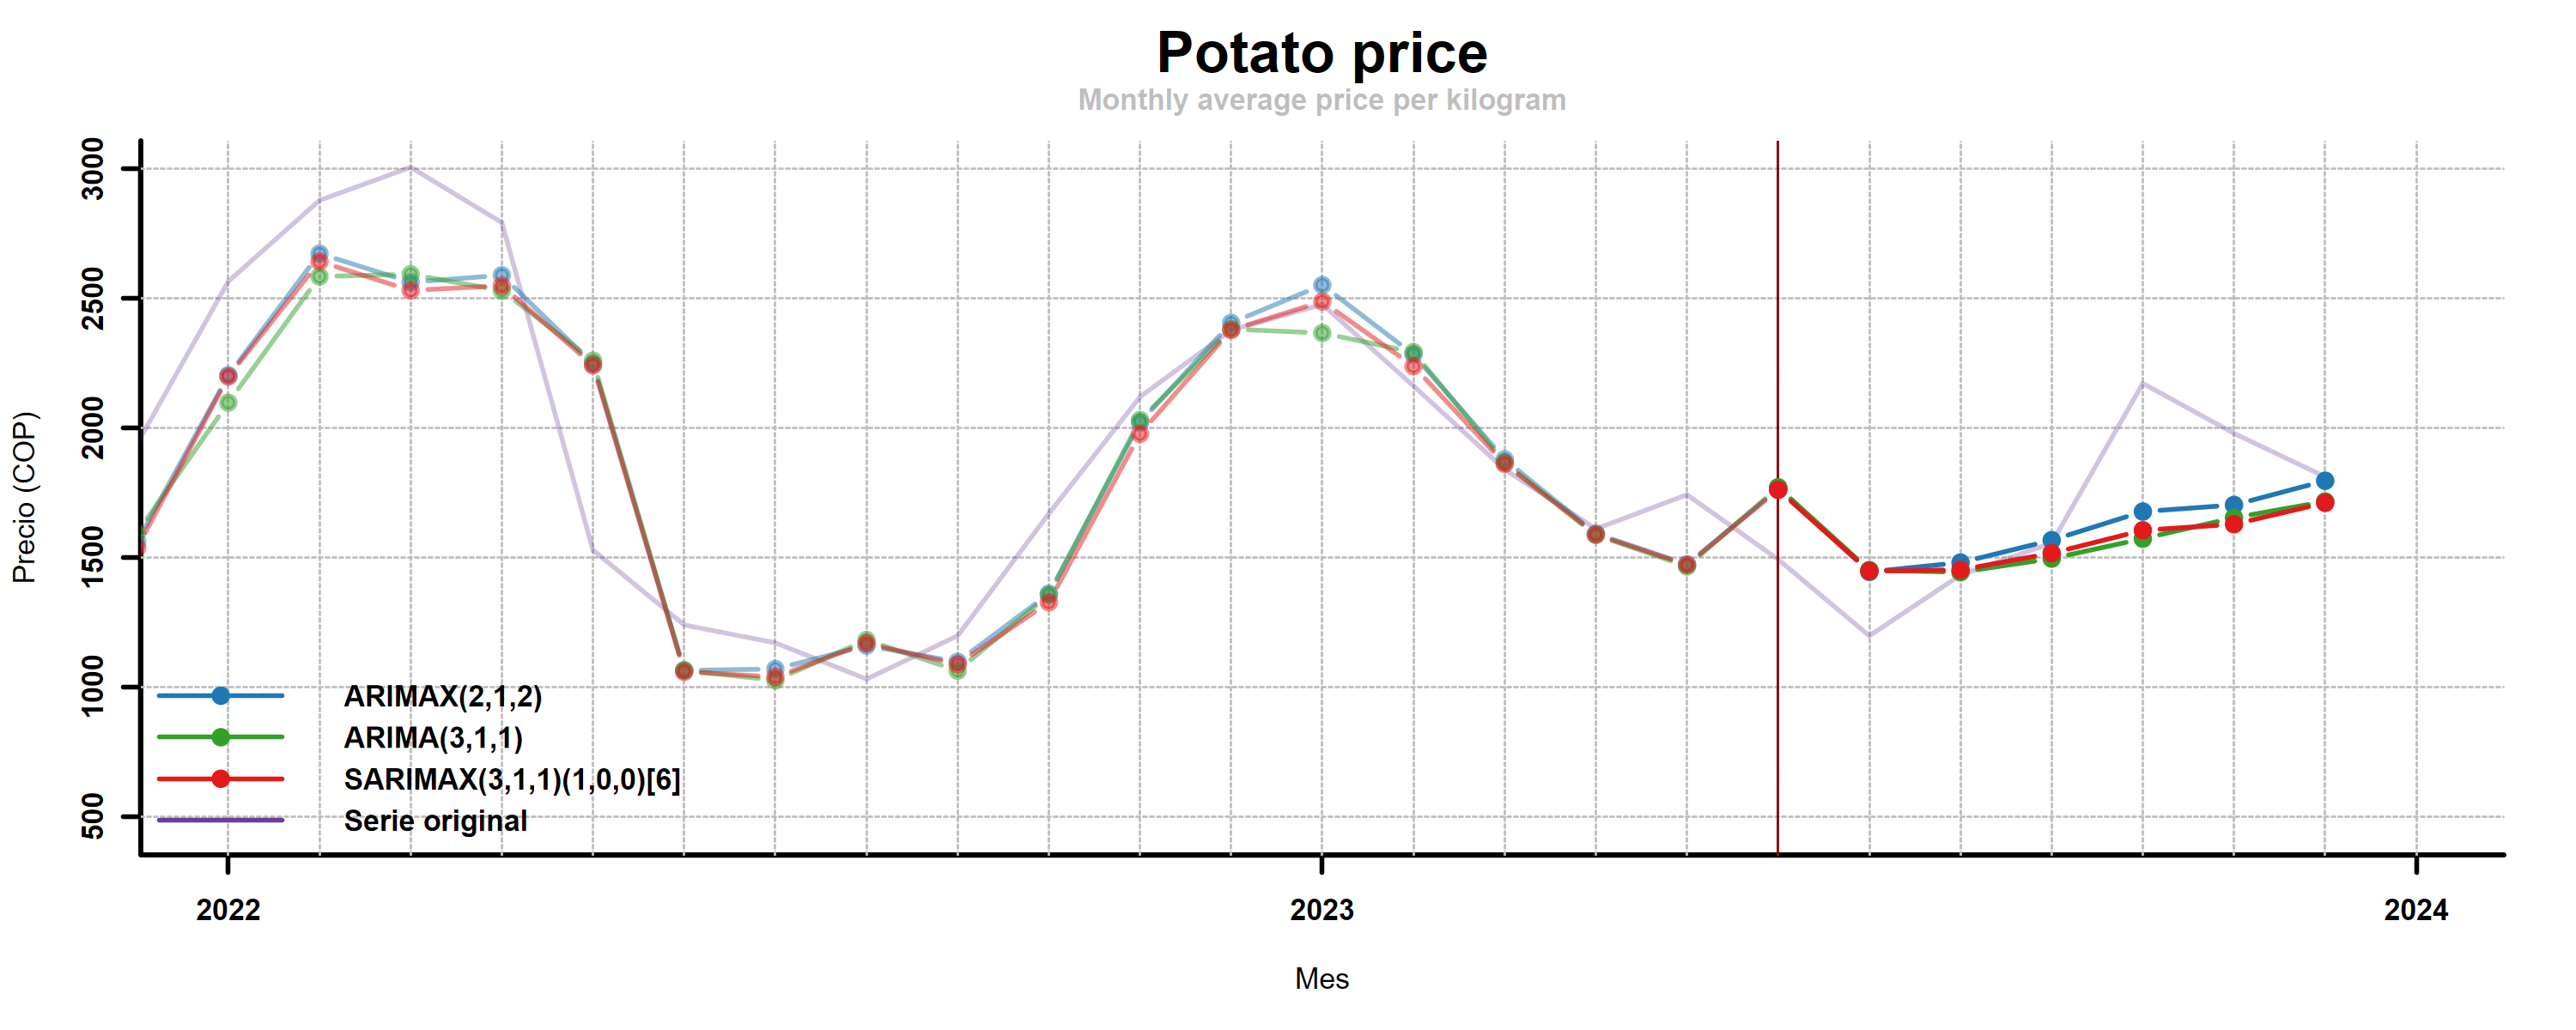

In [34]:
plot(papa, bty = 'n', type = 'n', ylab = 'Precio (COP)', xlab = 'Mes', xlim = c(2022, 2024), axes = F)
box(bty = 'l', lwd = 2)
title(main = 'Potato price', cex.main = 2, line = 2)
mtext(bquote(bold('Monthly average price per kilogram')), side = 3,
      col = 'gray', line = 0.6, cex = 1)
axis(1, at = 2022:2024, labels = 2022:2024, lwd = 2, font = 2); axis(2, lwd = 2, font = 2); box(bty = 'l', lwd = 2)
abline(h = seq(0, 5000, by = 500), col = 'gray', lty = 'dashed')
abline(v = seq(2021, 2024, by = 1/12), col = 'gray', lty = 'dashed')
lines(papa, col = adjustcolor(color, 0.3), lwd = 2)

for (i in 1:3){
    lines(selected_models[[i]]$fitted, lwd = 2, col = adjustcolor(colores[i*2], 0.5),
         type = 'b', pch = 19)
}


abline(v = time(papa)[114], col = 'darkred', lty = 'solid', lwd = 1)

for (i in 1:3){
    lines(x = time(papa)[114:120], y = predicciones[,i], lwd = 2, col = colores[i*2],
          type = 'b', pch = 19)
}

legend('bottomleft', legend = c(names(selected_models),'Serie original'), col = c(colores[1:3 * 2], color), 
      bty = 'n', pch = c(19,19,19, NA), lty = 'solid', lwd = 2, text.font = 2, y.intersp = 1.5)


In [35]:
# CUADRADO MEDIO DEL ERROR: 

apply(predicciones, MARGIN = 2, 
     function(x) mean((x[1] - papa[115:120])^2))

ARIMAX(2,1,2)             ARIMA(3,1,1) SARIMAX(3,1,1)(1,0,0)[6] 
                115226.7                 116034.6                 114625.4

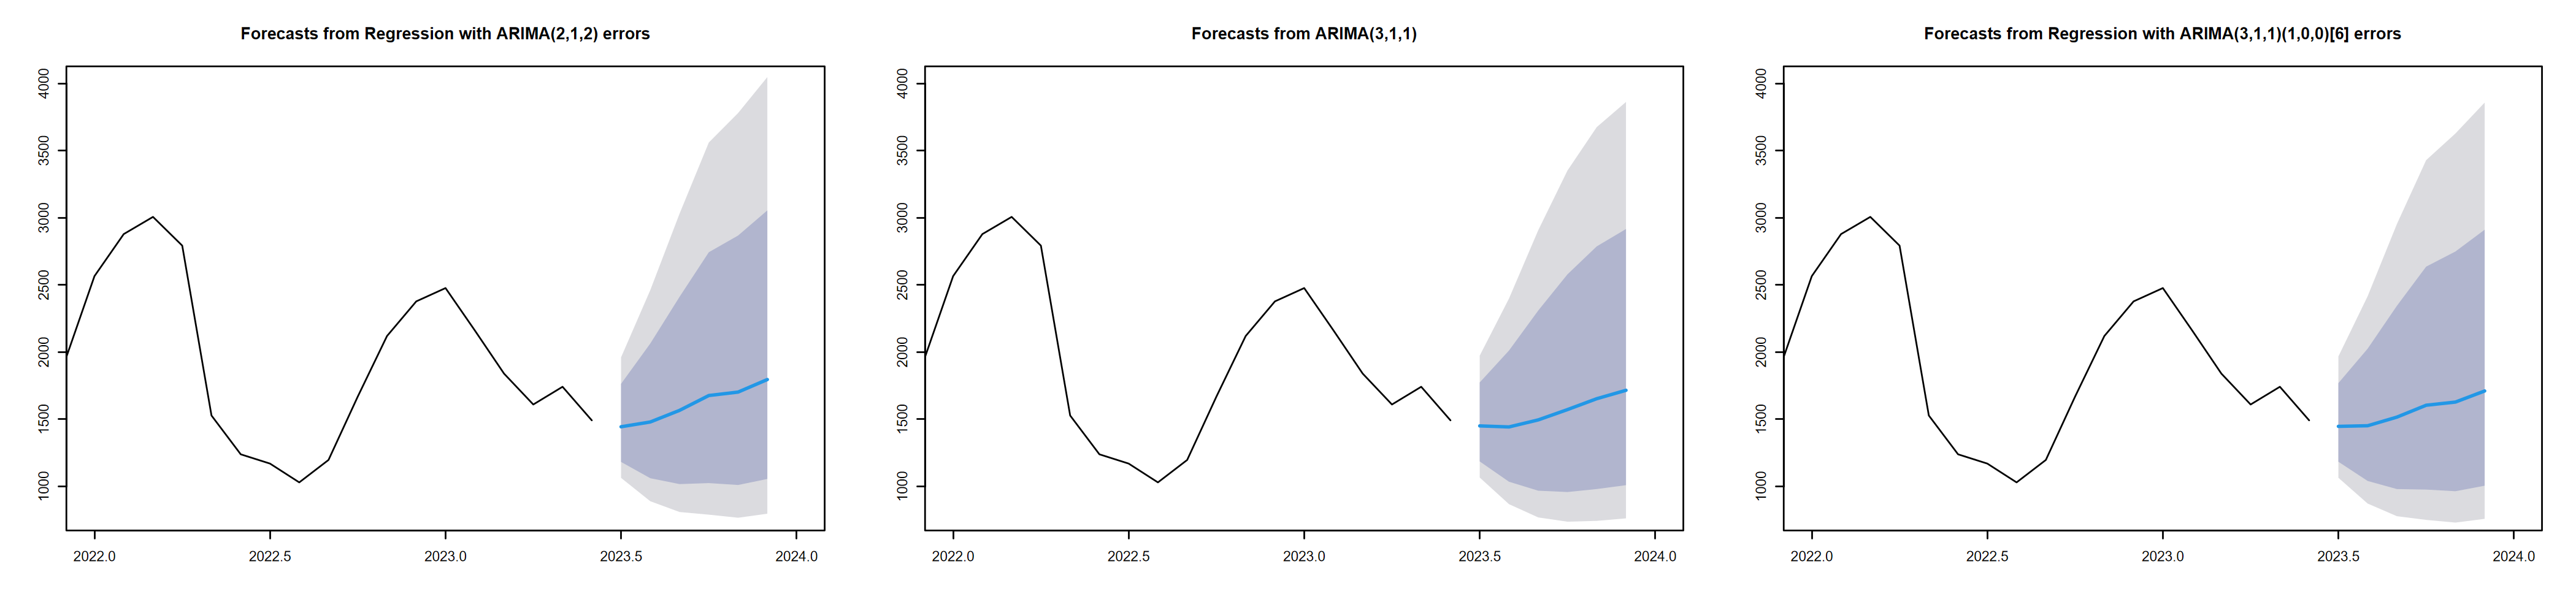

In [36]:
options(repr.plot.height = 5)
options(repr.plot.width = 21)
par(mfrow = c(1,3))
plot(forecast::forecast(selected_models[[1]], h = 6, xreg = log(exo[115:120])), xlim = c(2022, 2024), ylim = c(800, 4000))
plot(forecast::forecast(selected_models[[2]], h = 6), xlim = c(2022, 2024), ylim = c(800, 4000))
plot(forecast::forecast(selected_models[[3]], h = 6, xreg = log(exo[115:120])), xlim = c(2022, 2024), ylim = c(800, 4000))

In [37]:
options(repr.plot.height = 6)
options(repr.plot.width = 18)

par(mfrow = c(1,3))
lapply(selected_models, function(x) nsdiffs(x))

ERROR: Error in is.constant(x): 'list' object cannot be coerced to type 'double'


In [ ]:
save(selected_models,file =  'Modelos seleccionados.RData')

In [ ]:
do.call(rbind, lapply(selected_models, 
      FUN = function(x){
          residuales = x$residuals
          return(c(adf = adf.test(residuales)$p.value,
          kpss = kpss.test(residuales)$p.value,
          pp = pp.test(residuales)$p.value,
          ndiffs = ndiffs(residuales),
          nsdiffs = nsdiffs(residuales),
          lilliefors = nortest::lillie.test(residuales)$p.value,
          jarquevera = tseries::jarque.bera.test(residuales)$p.value,
          t.test = t.test(residuales)$p.value))
      }))

In [ ]:
papa[]

In [ ]:
options(repr.plot.height = 15)
options(repr.plot.width = 10)

par(mfrow = c(3,2))
a = lapply(names(selected_models), 
       function(y){
           x = selected_models[[y]]
           acf(x$residuals, main = paste('ACF', y), cex.main = 2)
           pacf(x$residuals, main = paste('PACF', y), cex.main = 2)
       })

In [ ]:
options(repr.plot.height = 5)
options(repr.plot.width = 10)
for (i in names(selected_models)){
    residuales = selected_models[[i]]
    sarima::tsdiag.Sarima(residuales, plot = c(1,3), layout = list(matrix(1:2, nrow = 1)))
}

In [ ]:
names(selected_models)

In [ ]:
options(repr.plot.height = 10)
options(repr.plot.width = 15)

par(mfrow = c(2,3))
a = lapply(names(selected_models), 
       function(y){
           x = selected_models[[y]]$residuals
           qqnorm(x, main = paste0('Normal Q-Q Plot ', y, ''))
           qqline(x, col = 'red')
       })
a = lapply(names(selected_models), 
       function(y){
           x = selected_models[[y]]$residuals
           hist(x, xlab = 'Histogram', col = colores[9], border = colores[9])
       })

In [434]:
coef = tsoutliers::coefs2poly(selected_models[[3]])
outliers <- tsoutliers::locate.outliers(selected_models[[3]]$residuals, coef)
outliers  # t-stat se compara con C=3


type,ind,coefhat,tstat
<fct>,<int>,<dbl>,<dbl>


In [38]:
selected_models

$`ARIMAX(2,1,2)`
Series: train 
Regression with ARIMA(2,1,2) errors 
Box Cox transformation: lambda= 0 

Coefficients:
         ar1      ar2      ma1     ma2    xreg
      1.5336  -0.7817  -1.2038  0.3203  0.0169
s.e.  0.0897   0.0983   0.1290  0.1505  0.0099

sigma^2 = 0.02436:  log likelihood = 51.45
AIC=-90.9   AICc=-90.11   BIC=-74.53

$`ARIMA(3,1,1)`
Series: train 
ARIMA(3,1,1) 
Box Cox transformation: lambda= 0 

Coefficients:
         ar1      ar2      ar3      ma1
      1.1871  -0.2922  -0.2185  -0.8743
s.e.  0.1151   0.1554   0.1048   0.0810

sigma^2 = 0.02469:  log likelihood = 50.13
AIC=-90.26   AICc=-89.7   BIC=-76.62

$`SARIMAX(3,1,1)(1,0,0)[6]`
Series: train 
Regression with ARIMA(3,1,1)(1,0,0)[6] errors 
Box Cox transformation: lambda= 0 

Coefficients:
         ar1      ar2      ar3      ma1    sar1    xreg
      1.2006  -0.3075  -0.2133  -0.8787  0.0174  0.0158
s.e.  0.1147   0.1569   0.1099   0.0791  0.1173  0.0100

sigma^2 = 0.02458:  log likelihood = 51.42
AIC=-88.8